## Load our cleaned DataFrames

In [ ]:
import pandas as pd
import seaborn as sns

# orders_cl.csv
url = "https://drive.google.com/file/d/1Tla62vfu__kCqvgypZyVt2S9VuC016yH/view?usp=sharing"
path = "https://drive.google.com/uc?export=download&id="+url.split("/")[-2]
orders_cl = pd.read_csv(path)

# orderlines_cl.csv
url = "https://drive.google.com/file/d/1OhtkQS2fwOYdzfd-qPh7im35iLc-L9TA/view?usp=sharing"
path = "https://drive.google.com/uc?export=download&id="+url.split("/")[-2]
orderlines_cl = pd.read_csv(path)

# products_cl.csv
url = "https://drive.google.com/file/d/1s7Lai4NSlsYjGEPg1QSOUJobNYVsZBOJ/view?usp=sharing"
path = "https://drive.google.com/uc?export=download&id="+url.split("/")[-2]
products_cl = pd.read_csv(path)

# brands.csv
url = "https://drive.google.com/file/d/1XGyabaa4mAkjixMk3XPgx_14OoSse3rs/view?usp=sharing"
path = "https://drive.google.com/uc?export=download&id="+url.split("/")[-2]
brands = pd.read_csv(path)

orders_cl.created_date = pd.to_datetime(orders_cl.created_date)
orderlines_cl.date = pd.to_datetime(orderlines_cl.date)

## 1.&nbsp; Define Pandas display format

In [ ]:
# your code here

pd.set_option('display.max_rows', 200)
pd.set_option("display.min_rows", 20)
pd.set_option("expand_frame_repr", True)
pd.set_option("colheader_justify", "right")
pd.set_option("max_colwidth", 40)

# do these two lines do the same?
pd.set_option('display.float_format', lambda x: '%.2f' % x)
# pd.set_option("display.precision", 2)

## 2.&nbsp; Exclude unwanted orders

In [ ]:
# your code here
orders_cl.state.value_counts()

Shopping Basket    117809
Completed           46605
Place Order         40883
Pending             14374
Cancelled            7233
Name: state, dtype: int64

In [ ]:
orders_qu = orders_cl.loc[orders_cl.state.isin(['Completed'])]
orders_qu.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 46605 entries, 1 to 226614
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   order_id      46605 non-null  int64         
 1   created_date  46605 non-null  datetime64[ns]
 2   total_paid    46605 non-null  float64       
 3   state         46605 non-null  object        
dtypes: datetime64[ns](1), float64(1), int64(1), object(1)
memory usage: 1.8+ MB


In [ ]:
valid_order_list = list(orders_qu.order_id)
len(valid_order_list)

46605

In [ ]:
orderlines_qu = orderlines_cl.loc[orderlines_cl.id_order.isin(valid_order_list)].copy()
orderlines_qu.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 56714 entries, 6 to 215949
Data columns (total 7 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   id                56714 non-null  int64         
 1   id_order          56714 non-null  int64         
 2   product_id        56714 non-null  int64         
 3   product_quantity  56714 non-null  int64         
 4   sku               56714 non-null  object        
 5   unit_price        56714 non-null  float64       
 6   date              56714 non-null  datetime64[ns]
dtypes: datetime64[ns](1), float64(1), int64(4), object(1)
memory usage: 3.5+ MB


In [ ]:
orderlines_qu.id_order.nunique(), orders_qu.order_id.nunique()

(43064, 46605)

In [ ]:
valid_order_list = list(set(orderlines_qu.id_order) & set(orders_qu.order_id))
len(valid_order_list)

43064

In [ ]:
orderlines_qu = orderlines_cl.loc[orderlines_cl.id_order.isin(valid_order_list)]
orders_qu = orders_qu.loc[orders_qu.order_id.isin(valid_order_list)]
orderlines_qu.id_order.nunique(), orders_qu.order_id.nunique()

(43064, 43064)

## 3.&nbsp; Exclude orders with unknown products


In [ ]:
# your code here
valid_sku_list = list(products_cl.sku)
orderlines_qu.sku.isin(valid_sku_list).value_counts()

True     55320
False     1394
Name: sku, dtype: int64

In [ ]:
invalid_order_list = list(orderlines_qu.loc[~orderlines_qu.sku.isin(valid_sku_list)]['id_order'])
orderlines_qu = orderlines_qu.loc[~orderlines_qu['id_order'].isin(invalid_order_list)]
orders_qu = orders_qu.loc[~orders_qu['order_id'].isin(invalid_order_list)]
orderlines_qu.id_order.nunique(), orders_qu.order_id.nunique()

(41701, 41701)

## 4.&nbsp; Explore the revenue from different tables

#### Step 1:
Create the `unit_price_total` as `orderlines.unit_price` * `orderlines.product_quantity`

In [ ]:
# your code here
orderlines_qu['unit_sum'] = orderlines_qu.unit_price * orderlines_qu.product_quantity

<ipython-input-148-c84638a9e6b9>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  orderlines_qu['unit_sum'] = orderlines_qu.unit_price * orderlines_qu.product_quantity


#### Step 2:
Group by `order_id`, summarising by the sum of `unit_price_total`

In [ ]:
# your code here
orders_qu_work = orders_qu.copy()
orderlines_qu_work = orderlines_qu.groupby(by='id_order')['unit_sum'].sum().reset_index().rename(columns={'unit_sum': 'sum'})
orderlines_qu.info()
orderlines_qu_work.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 54324 entries, 6 to 215949
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   id                54324 non-null  int64         
 1   id_order          54324 non-null  int64         
 2   product_id        54324 non-null  int64         
 3   product_quantity  54324 non-null  int64         
 4   sku               54324 non-null  object        
 5   unit_price        54324 non-null  float64       
 6   date              54324 non-null  datetime64[ns]
 7   unit_sum          54324 non-null  float64       
dtypes: datetime64[ns](1), float64(2), int64(4), object(1)
memory usage: 3.7+ MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41701 entries, 0 to 41700
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   id_order  41701 non-null  int64  
 1   sum       41701 non-null  float64
dtypes

In [ ]:
orderlines_qu_work.head(5)


,id_order,sum
0,241423,129.16
1,242832,10.77
2,243330,77.99
3,245275,149.00
4,245595,105.98


### What is the average difference between `total_paid` and `unit_price_total`?

In [ ]:
# your code here
order_sales = orders_qu_work.merge(orderlines_qu_work, left_on="order_id", right_on="id_order")
order_sales['order_sum_difference'] = order_sales['total_paid'] - order_sales['sum']
order_sales.order_sum_difference.mean().round(2)

4.47

In [ ]:
order_sales.head()

,order_id,created_date,total_paid,state,id_order,sum,order_sum_difference
0,241423,2017-11-06 13:10:02,136.15,Completed,241423,129.16,6.99
1,242832,2017-12-31 17:40:03,15.76,Completed,242832,10.77,4.99
2,243330,2017-02-16 10:59:38,84.98,Completed,243330,77.99,6.99
3,245275,2017-06-28 11:35:37,149.00,Completed,245275,149.00,0.00
4,245595,2017-01-21 12:52:47,112.97,Completed,245595,105.98,6.99


### What is the distribution of these differences?

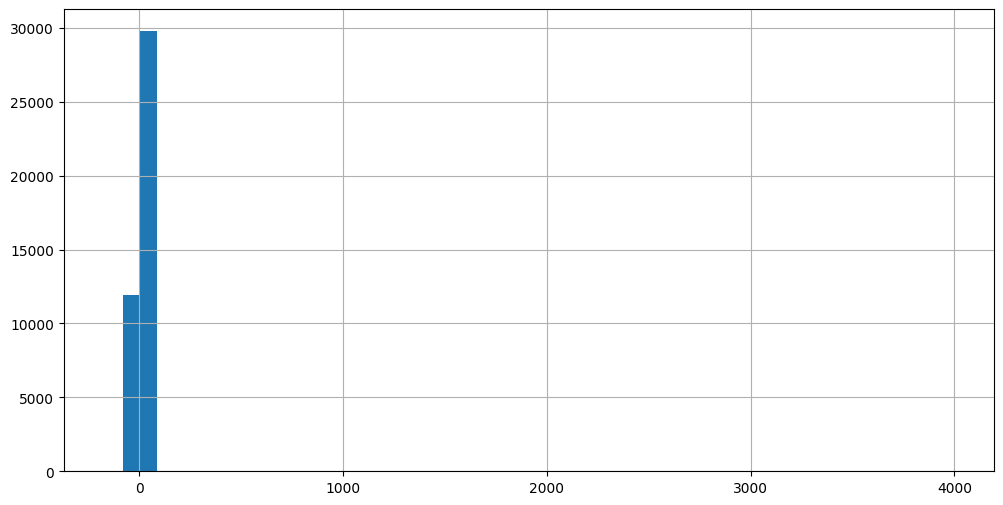

In [ ]:
# your code here
order_sales.order_sum_difference.hist(bins= 50, figsize=(12,6));

In [ ]:
order_sales.describe()

,order_id,total_paid,id_order,sum,order_sum_difference
count,41701.00,41701.00,41701.00,41701.00,41701.00
mean,414946.28,195.64,414946.28,191.16,4.47
std,65923.10,251.86,65923.10,251.02,26.05
min,241423.00,0.00,241423.00,2.49,-165.00
25%,362647.00,46.98,362647.00,41.99,0.00
50%,417815.00,98.98,417815.00,94.97,4.99
75%,470878.00,246.98,470878.00,241.98,6.99
max,527112.00,6876.94,527112.00,6876.80,3984.99


In [ ]:
# let's see how values look and if there are frequent values
order_sales['order_sum_difference'].value_counts()

0.00       10476
6.99        4559
4.99        3419
4.99        2523
4.99        2351
6.99        1889
3.99        1882
3.99        1620
3.99        1463
6.99        1305
           ...  
5.01           1
2.73           1
5.00           1
4.00           1
0.16           1
-165.00        1
0.14           1
0.04           1
5.00           1
10.01          1
Name: order_sum_difference, Length: 335, dtype: int64

In [ ]:
# find out what different values are there if we round to 1 decimal sign
# it excludes "noise", which might be connected with e.g. bank transaction
order_sales['order_sum_difference'].round(1).value_counts()

0.00       11648
5.00       11231
7.00       10275
4.00        6901
20.00        626
10.00        467
12.00        115
-5.00        114
-1.00        108
2.00          75
15.00         23
-20.00        11
13.00          7
-21.00         7
-25.00         6
21.00          5
4.10           5
-18.00         4
0.10           3
-41.90         2
-13.00         2
-38.90         2
5.80           2
7.10           2
51.00          2
61.00          2
24.00          2
169.00         1
36.90          1
115.00         1
38.90          1
57.00          1
320.00         1
79.60          1
160.70         1
17.00          1
25.00          1
-120.00        1
1681.60        1
14.00          1
42.30          1
26.00          1
253.00         1
386.80         1
40.00          1
256.00         1
31.30          1
34.00          1
239.90         1
77.00          1
391.90         1
163.00         1
19.00          1
1298.60        1
93.00          1
-82.00         1
2569.00        1
181.00         1
3985.00       

In [ ]:
# defining outliers based on IQR
Q1 = order_sales['order_sum_difference'].quantile(0.25)
Q3 = order_sales['order_sum_difference'].quantile(0.75)
IQR = Q3 - Q1
bottom_limit = Q1 - 1.5*IQR
upper_limit = Q3 + 1.5*IQR

# choosing the percentage of data to save
# upper_limit = order_sales['order_sum_difference'].quantile(0.99)
# bottom_limit = order_sales['order_sum_difference'].quantile(0.01)

# or based on different values of rounded difference
# upper_limit = 70
# bottom_limit = -40


In [ ]:
# how much data lays in the limits chosen for outliers definition
order_sales.loc[(order_sales['order_sum_difference'].between(bottom_limit, upper_limit))]['order_sum_difference'].count() / order_sales['order_sum_difference'].count()

0.9828301479580825

In [ ]:
# DROPPING outliers
order_sales_outliers = order_sales.loc[(~order_sales['order_sum_difference'].between(bottom_limit, upper_limit))].copy()
order_sales_no_outliers = order_sales.loc[(order_sales['order_sum_difference'].between(bottom_limit, upper_limit))].copy()

Some orders have negative values of (`total_paid` - `unit_sum`)

In [ ]:
order_sales_no_outliers.loc[order_sales_no_outliers['order_sum_difference'] < 0, 'order_sum_difference'].value_counts().head(20)

-0.01    113
-0.00    101
-5.00     95
-0.00     73
-0.00     64
-0.01     46
-1.01     38
-0.00     37
-1.01     36
-0.00     24
-0.01     23
-1.01     19
-0.01     19
-1.01     15
-0.00     10
-0.01      8
-5.00      6
-0.00      5
-0.01      5
-0.01      4
Name: order_sum_difference, dtype: int64

In [ ]:
# Share of negative values in %
order_sales.loc[order_sales['order_sum_difference'] < 0]['order_sum_difference'].count() / order_sales.order_id.count() * 100

1.937603414786216

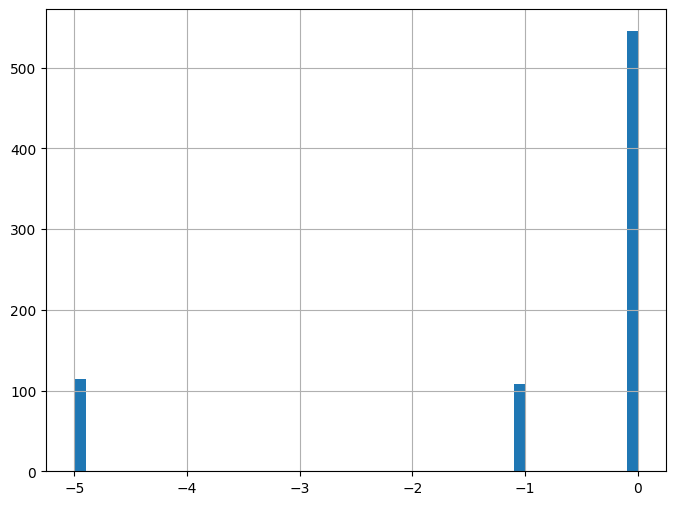

In [ ]:
order_sales_no_outliers.loc[order_sales_no_outliers['order_sum_difference'] < 0, 'order_sum_difference'].hist(bins= 50, figsize=(8,6));

### Can all the differences be explained by shipping costs? If not, what are other plausible explanations?

In [ ]:
# your explanation here
# Hypothesis: difference consists of 3 components: shipping cost,
# "noise" (several cents, might be connected with banks transaction or payment system),
# personal or special discount (loyality card, extra discount for each following item)

### If there are differences that you can’t explain: what should you do with these orders?

<Axes: >

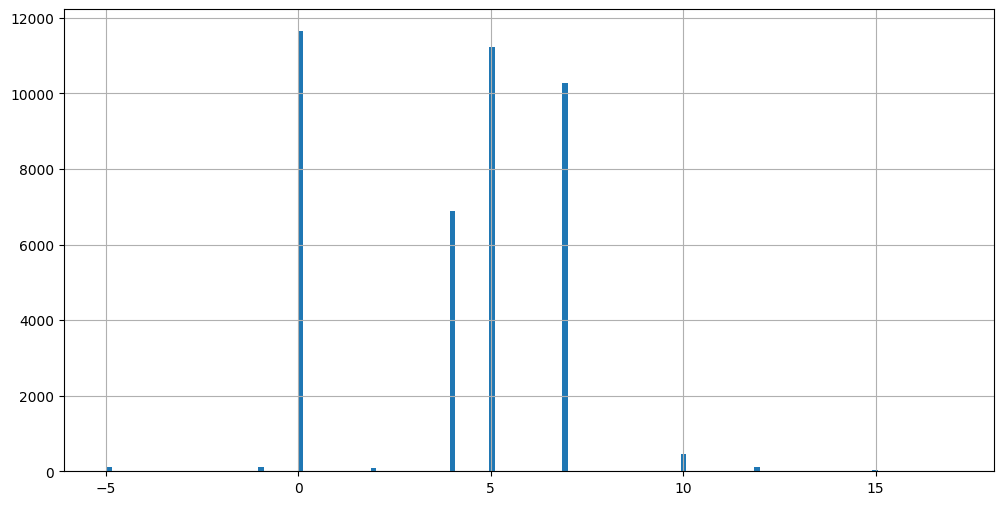

In [ ]:
order_sales_no_outliers['order_sum_difference'].hist(bins= 150, figsize=(12,6))

In [ ]:
order_sales_no_outliers.order_sum_difference.astype(str).value_counts().sort_values(ascending=False).head(10)


0.0                  10476
6.990000000000009     4559
4.990000000000009     3419
4.990000000000002     2523
4.989999999999995     2351
6.989999999999995     1889
3.990000000000009     1882
3.990000000000002     1620
3.989999999999995     1463
6.990000000000002     1305
Name: order_sum_difference, dtype: int64

In [ ]:
order_sales_no_outliers.describe()

,order_id,total_paid,id_order,sum,order_sum_difference
count,40985.00,40985.00,40985.00,40985.00,40985.00
mean,414728.34,194.67,414728.34,190.73,3.94
std,65935.02,250.51,65935.02,251.33,2.83
min,241423.00,2.82,241423.00,2.49,-5.00
25%,362317.00,46.98,362317.00,41.97,0.00
50%,417508.00,98.04,417508.00,94.05,4.99
75%,470672.00,244.99,470672.00,240.33,6.99
max,527112.00,6876.94,527112.00,6876.80,16.97


### Drop outliers and save dataframes as _qu (quality_checked)

In [ ]:
# define list of orders with outliners and drop these orders from orders_cl and orderlines_cl
normal_diff_list = list(order_sales_no_outliers["order_id"])
orders_qu = orders_qu.loc[orders_qu["order_id"].isin(normal_diff_list), :]
orderlines_qu = orderlines_cl.loc[orderlines_cl["id_order"].isin(normal_diff_list), :]

In [ ]:
# checking the size of dataframes
len(list(orders_qu["order_id"].unique())), len(list(orderlines_qu["id_order"].unique()))

(40985, 40985)

## Explore the discounts

In [ ]:
# creating dataframe with discount values:
# - merge orderlines and products
# - add columns: discount, discount_percentage (discount), unit_sum (revenue of an orderline)
orderlines_discount = orderlines_qu.merge(products_cl, how='left', on='sku')
orderlines_discount['discount'] = orderlines_discount.price - orderlines_discount.unit_price
orderlines_discount['discount_percent'] = 100 * orderlines_discount.discount / orderlines_discount.price
orderlines_discount['unit_sum'] = orderlines_discount.unit_price * orderlines_discount.product_quantity
orderlines_discount["short"] = orderlines_discount["sku"].str[:3]
orderlines_discount = orderlines_discount.merge(brands,
                                how="left",
                                left_on="short",
                                right_on="short")
orderlines_discount.drop(columns='short', inplace=True)
orderlines_discount_qu = orderlines_discount.copy()
# orderlines_discount.head(5)

In [ ]:
# orderlines_discount.info()

In [ ]:
# orderlines_discount.sort_values('discount_percent', ascending=True).head(5)

In [ ]:
# orderlines_discount.sort_values('discount', ascending=False).head(20)

There are two scenarios:
1. drop outliers based on the formula with IQR
2. drop negative values and leave all others since maximum values look reasonable in combination with prices

### SCENARIO 1(optional): dropping outliers based on the formula with IRQ


In [ ]:
# defining outliers based on IQR
Q1 = orderlines_discount_qu.discount.quantile(0.25)
Q3 = orderlines_discount_qu.discount.quantile(0.75)
IQR = Q3 - Q1
bottom_limit = Q1 - 1.5*IQR
upper_limit = Q3 + 1.5*IQR

orderlines_discount_no_outliers = orderlines_discount_qu.loc[orderlines_discount_qu.discount.between(bottom_limit, upper_limit)].copy()
orderlines_discount_outliers = orderlines_discount_qu.loc[~orderlines_discount_qu.discount.between(bottom_limit, upper_limit)].copy()

orderlines_discount_no_outliers.describe()

,id,id_order,product_id,product_quantity,unit_price,price,in_stock,discount,discount_percent,unit_sum
count,48795.00,48795.00,48795.00,48795.00,48795.00,48795.00,48795.00,48795.00,48795.00,48795.00
mean,1383767.86,413669.46,0.00,1.13,112.55,130.41,0.59,17.87,20.68,122.77
std,150736.00,65437.78,0.00,0.83,152.60,159.21,0.49,16.98,17.54,180.19
min,1119116.00,241423.00,0.00,1.00,1.99,2.99,0.00,-33.00,-212.27,1.99
25%,1262000.00,361680.50,0.00,1.00,24.99,35.00,0.00,5.00,8.34,26.34
50%,1386706.00,415838.00,0.00,1.00,56.31,73.98,1.00,13.20,16.80,59.99
75%,1511397.50,469264.00,0.00,1.00,129.00,154.99,1.00,25.00,27.79,139.99
max,1649593.00,527112.00,0.00,72.00,999.99,1059.00,1.00,69.46,97.14,6876.80


In [ ]:
orderlines_discount_outliers.describe()

,id,id_order,product_id,product_quantity,unit_price,price,in_stock,discount,discount_percent,unit_sum
count,4436.00,4436.00,4436.00,4436.00,4436.00,4436.00,4436.00,4436.00,4436.00,4436.00
mean,1395171.14,418677.11,0.00,1.09,387.78,504.66,0.34,116.88,29.11,411.76
std,154736.76,67017.15,0.00,0.68,257.55,291.29,0.48,112.85,22.43,303.22
min,1119145.00,260615.00,0.00,1.00,4.99,74.99,0.00,-170.99,-81.34,9.98
25%,1275411.50,368706.25,0.00,1.00,204.58,299.99,0.00,78.00,17.27,214.21
50%,1418045.00,429670.00,0.00,1.00,327.35,429.00,0.00,100.00,24.06,340.60
75%,1528610.00,477251.25,0.00,1.00,559.01,699.00,1.00,130.33,35.25,597.67
max,1648968.00,526771.00,0.00,32.00,999.00,1799.00,1.00,1320.00,94.45,5799.80


In [ ]:
# too many outliers, checking another limits
upper_limit = 200

orderlines_discount_no_outliers = orderlines_discount_qu.loc[orderlines_discount_qu.discount.between(bottom_limit, upper_limit)].copy()
orderlines_discount_outliers = orderlines_discount_qu.loc[~orderlines_discount_qu.discount.between(bottom_limit, upper_limit)].copy()
orderlines_discount_no_outliers.describe()

,id,id_order,product_id,product_quantity,unit_price,price,in_stock,discount,discount_percent,unit_sum
count,52579.00,52579.00,52579.00,52579.00,52579.00,52579.00,52579.00,52579.00,52579.00,52579.00
mean,1385372.69,414361.26,0.00,1.13,129.72,153.77,0.58,24.05,21.43,140.91
std,151164.45,65614.49,0.00,0.82,172.14,187.76,0.49,28.73,17.92,201.01
min,1119116.00,241423.00,0.00,1.00,1.99,2.99,0.00,-33.00,-212.27,1.99
25%,1263750.00,362455.00,0.00,1.00,26.12,35.99,0.00,5.37,9.10,28.99
50%,1389375.00,417225.00,0.00,1.00,62.99,79.99,1.00,15.00,17.53,66.99
75%,1513439.00,469941.00,0.00,1.00,149.99,179.00,1.00,30.00,28.58,160.55
max,1649593.00,527112.00,0.00,72.00,999.99,1159.00,1.00,200.00,97.14,6876.80


In [ ]:
orderlines_discount_outliers.describe()

,id,id_order,product_id,product_quantity,unit_price,price,in_stock,discount,discount_percent,unit_sum
count,652.00,652.00,652.00,652.00,652.00,652.00,652.00,652.00,652.00,652.00
mean,1331934.78,391951.37,0.00,1.04,600.44,793.39,0.15,192.94,17.05,626.18
std,136335.87,59133.60,0.00,0.21,240.86,317.28,0.36,273.34,31.32,291.97
min,1119254.00,284739.00,0.00,1.00,135.99,74.99,0.00,-170.99,-81.34,135.99
25%,1243836.25,352802.75,0.00,1.00,389.74,639.00,0.00,-62.75,-15.60,398.89
50%,1301988.00,381673.00,0.00,1.00,642.95,799.00,0.00,220.00,24.03,649.00
75%,1433088.25,436720.75,0.00,1.00,810.75,1015.59,0.00,300.00,37.38,829.00
max,1648662.00,526615.00,0.00,3.00,999.00,1799.00,1.00,1320.00,82.95,2727.00


<Axes: ylabel='Frequency'>

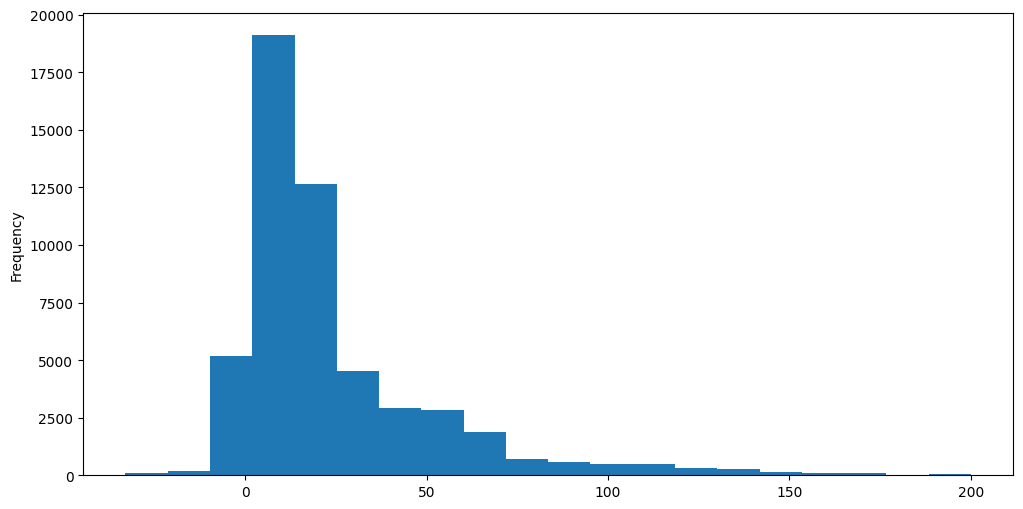

In [ ]:
orderlines_discount_no_outliers.discount.plot.hist(bins=20, figsize=(12,6))

### SCENARIO 2(default): dropping only negative values


In [ ]:
# save negative disounts in `orderlines_neg_discount`
orderlines_neg_discount = orderlines_discount_qu.loc[orderlines_discount_qu.discount < 0].copy()
orderlines_neg_discount.discount.count()

1571

In [ ]:
# drop negative discounts
bottom_limit = 0
upper_limit = orderlines_discount_qu.discount.max()
orderlines_discount_no_outliers = orderlines_discount_qu.loc[orderlines_discount_qu.discount.between(bottom_limit, upper_limit)].copy()
orderlines_discount_no_outliers.discount.count()

51660

In [ ]:
# dataset with zero discounts
orderlines_zero_discount = orderlines_discount_qu.loc[orderlines_discount_qu.discount == 0].copy()
orderlines_zero_discount.discount.count()

2256

In [ ]:
# total sales in orderlines_discounts_no_outliers
orderlines_discount_no_outliers.unit_sum.sum().round(2)

7483721.46

In [ ]:
# total sales in inital orderlines_discount
orderlines_discount.unit_sum.sum()

7817204.4

In [ ]:
# share of sales left after dropping outliers
orderlines_discount_no_outliers.unit_sum.sum().round(2) / orderlines_discount.unit_sum.sum() * 100

95.73398720391653

In [ ]:
# orderlines_discount_no_outliers.info()

### Saving dataframe as quality-checked

In [ ]:
# saving dataframe as quality-checked
orderlines_discount_qu = orderlines_discount_no_outliers
# orderlines_discount_qu.info()

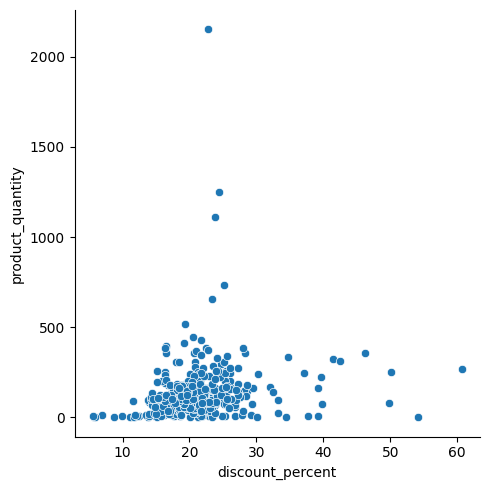

In [ ]:
data_vs_days = orderlines_discount_qu.resample(
    'D', on='date'
    ).agg(
        {'discount_percent': 'mean',
         'unit_sum': 'sum',
         'product_quantity': 'sum'}).copy()
data_vs_days
sns.relplot(data=data_vs_days, x='discount_percent', y='product_quantity')

## Define categories

In [ ]:
# DEFINING CATEGORIES

# setting "price_category"
# price_bins = [0, 100, 250, 500, 1000, orderlines_discount_qu.price.max()]

# orderlines_discount_qu['price_category'] = pd.cut(x=orderlines_discount_qu['price'],
#                                                  bins=price_bins,
#                                                  labels=['0-100', '100-250', '250-500', '500-1000', '1000-max'])
# price_bins = [0, 50, 100, 250, 500, 1000, orderlines_discount_qu.price.max()]
# orderlines_discount_qu['price_category'] = pd.cut(x=orderlines_discount_qu['price'],
#                                                  bins=price_bins,
#                                                  labels=['0-50', '50-100', '100-250', '250-500', '500-1000', '1000-max'])

# setting "discount_category"
discount_bins = [0, 20, 40, 60, 80, 100]
orderlines_discount_qu['discount_category'] = pd.cut(x=orderlines_discount_qu['discount_percent'],
                                                     bins=discount_bins,
                                                     labels=['0-20', '20-40', '40-60', '60-80', '80-100'])

# adding a column "refurbished"
orderlines_discount_qu['refurbished'] = 'no'
orderlines_discount_qu.loc[orderlines_discount_qu["desc"].str.contains("refurbish", case=False) | orderlines_discount_qu["desc"].str.contains("reconditioned", case=False) | orderlines_discount_qu["desc"].str.contains("used", case=False), "refurbished"] = 'yes'
orderlines_discount_qu.loc[orderlines_discount_qu["desc"].str.contains("refurbish", case=False)]

# adding date_day and date_week columns
orderlines_discount_qu['date_day'] = orderlines_discount_qu['date'].dt.date
orderlines_discount_qu['date_week'] = orderlines_discount_qu['date'].dt.strftime('%Y-w%W')
# orderlines_discount_qu[['date', 'date_week', 'date_day']].sample(5)
orderlines_discount_qu.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 51660 entries, 0 to 53230
Data columns (total 20 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   id                 51660 non-null  int64         
 1   id_order           51660 non-null  int64         
 2   product_id         51660 non-null  int64         
 3   product_quantity   51660 non-null  int64         
 4   sku                51660 non-null  object        
 5   unit_price         51660 non-null  float64       
 6   date               51660 non-null  datetime64[ns]
 7   name               51660 non-null  object        
 8   desc               51660 non-null  object        
 9   price              51660 non-null  float64       
 10  in_stock           51660 non-null  int64         
 11  type               51653 non-null  object        
 12  discount           51660 non-null  float64       
 13  discount_percent   51660 non-null  float64       
 14  unit_s

array([<Axes: xlabel='date'>, <Axes: xlabel='date'>,
       <Axes: xlabel='date'>], dtype=object)

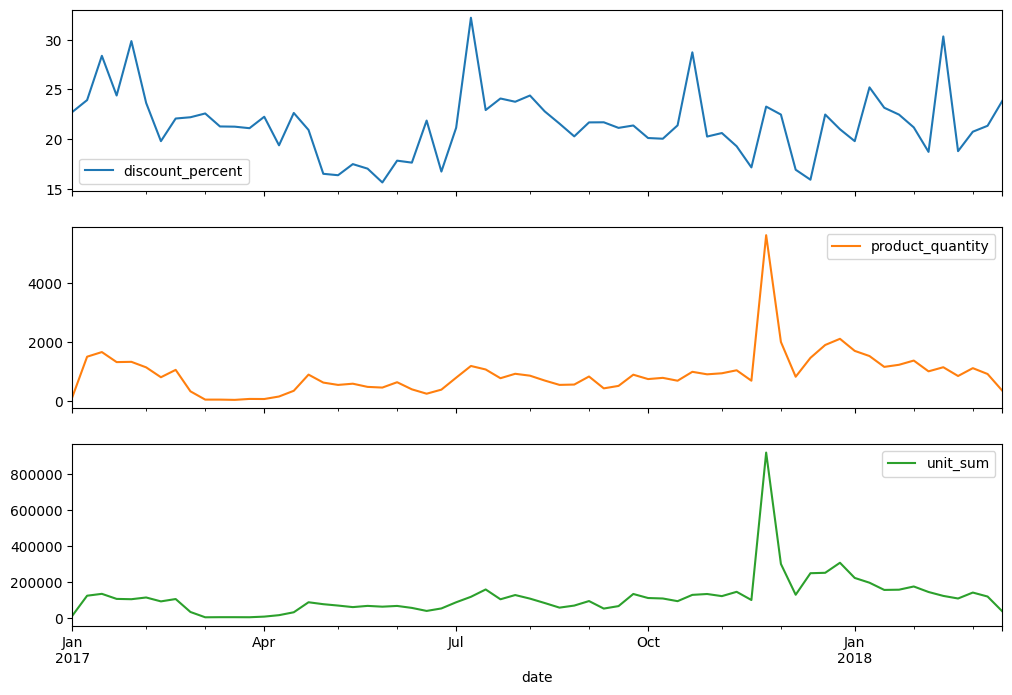

In [ ]:
# set up a dataframe for quick analysis of sales revenue, sales quantity, average discount vs time
data_vs_time = orderlines_discount_qu.resample(
    'W', on='date'
    ).agg(
        {'discount_percent': 'mean',
         'unit_sum': 'sum',
         'product_quantity': 'sum'}).copy()

data_vs_time.plot(kind='line',
                  y=['discount_percent', 'product_quantity', 'unit_sum'],
                  subplots=True,
                  figsize=(12,8))


# sns.relplot(kind='line', data=data_vs_time, sharey=False, row= height=9, aspect=2)
# sns.relplot(kind='line', data=data_vs_time, x=index, y='discount_percent', height=4, aspect=2)

<Axes: ylabel='Frequency'>

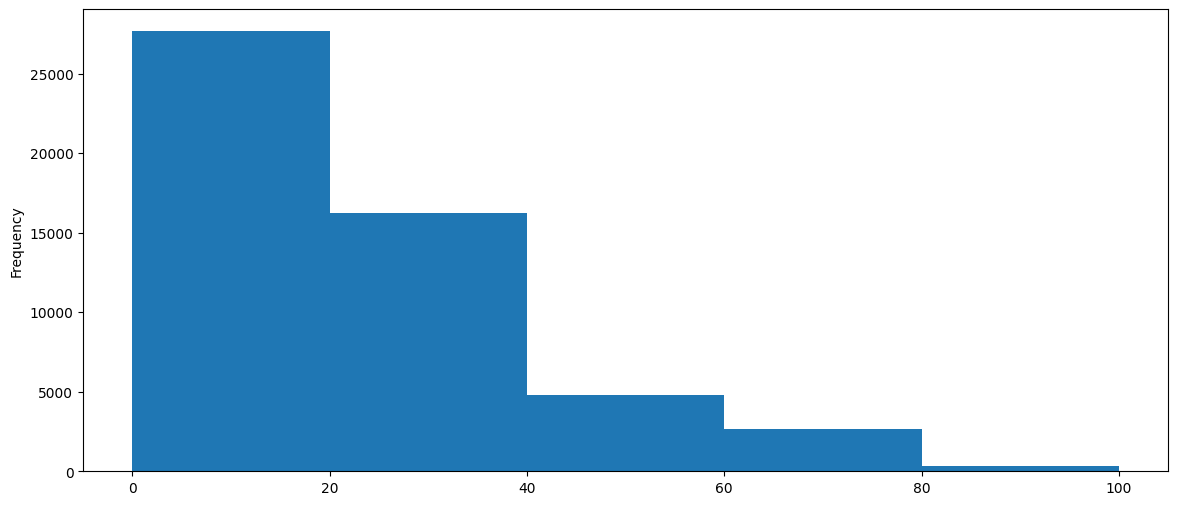

In [ ]:
# distribution of discount_percent
orderlines_discount_no_outliers.discount_percent.plot.hist(
    bins=discount_bins,
    figsize=(14,6)
    )

<Axes: ylabel='Frequency'>

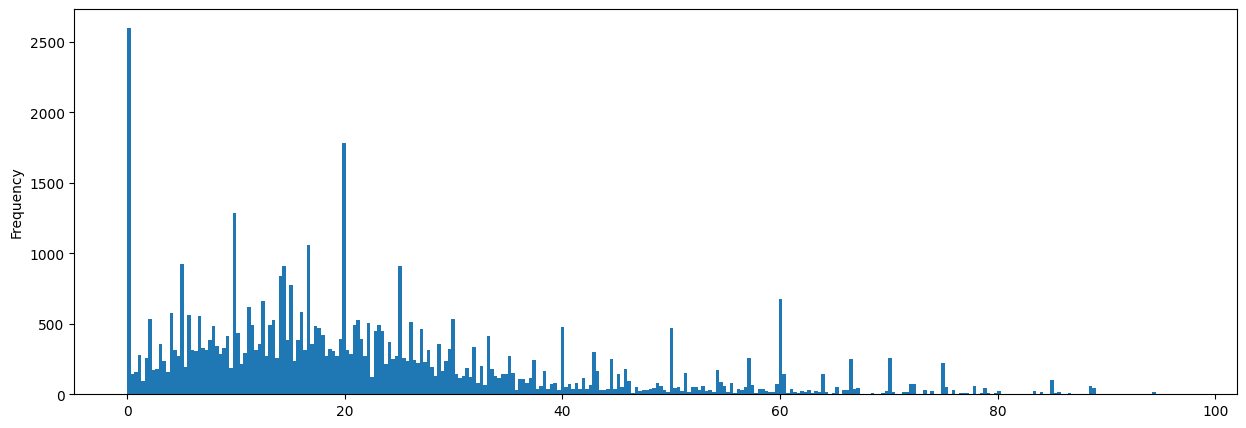

In [ ]:
orderlines_discount_no_outliers.discount_percent.plot.hist(
    bins=300,
    figsize=(15,5)
    )

<Axes: xlabel='discount_percent'>

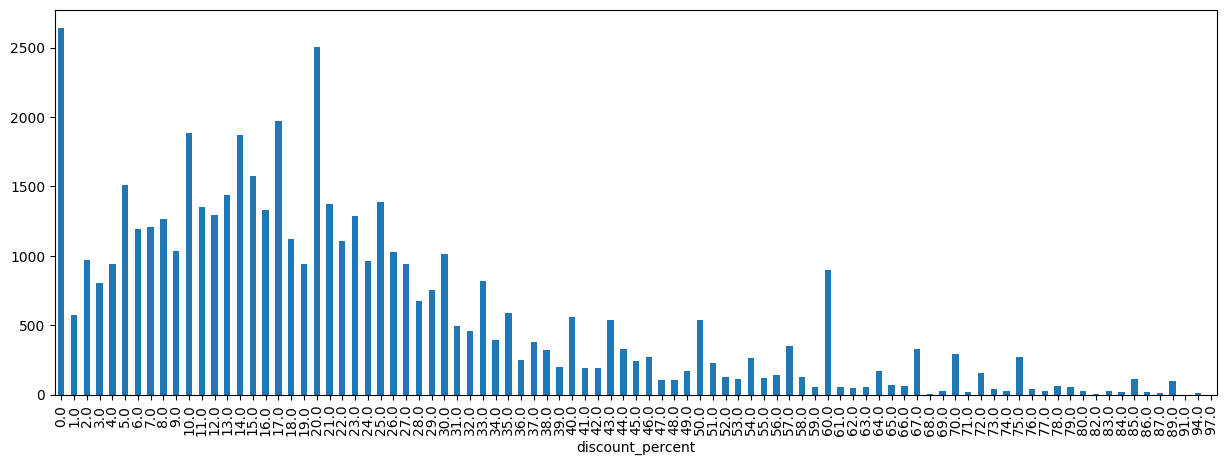

In [ ]:
# distribution of discount_percentage if round(0)
orderlines_discount_qu["discount_percent"].round(0).groupby(orderlines_discount_qu["discount_percent"].round(0)).count().plot.bar(figsize=(15,5))

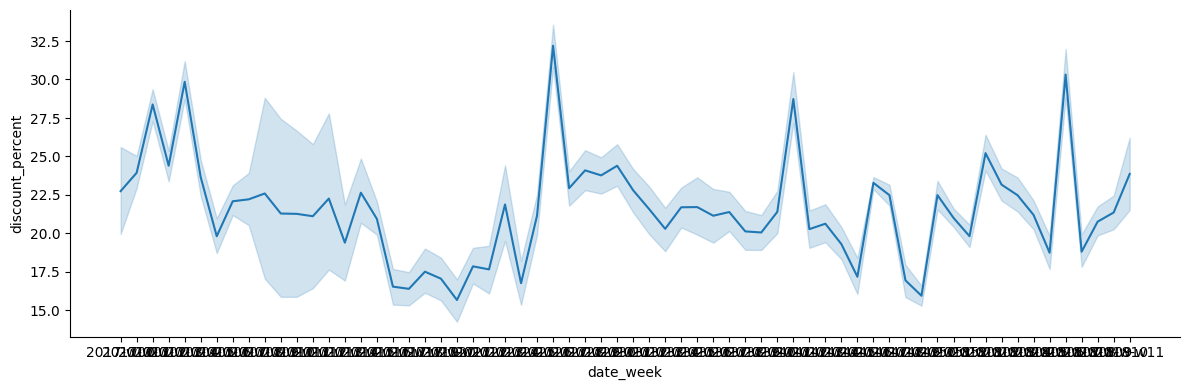

In [ ]:
# discount_percent distribution throught time
sns.relplot(kind='line', data=orderlines_discount_no_outliers, x='date_week', y='discount_percent', height=4, aspect=3)

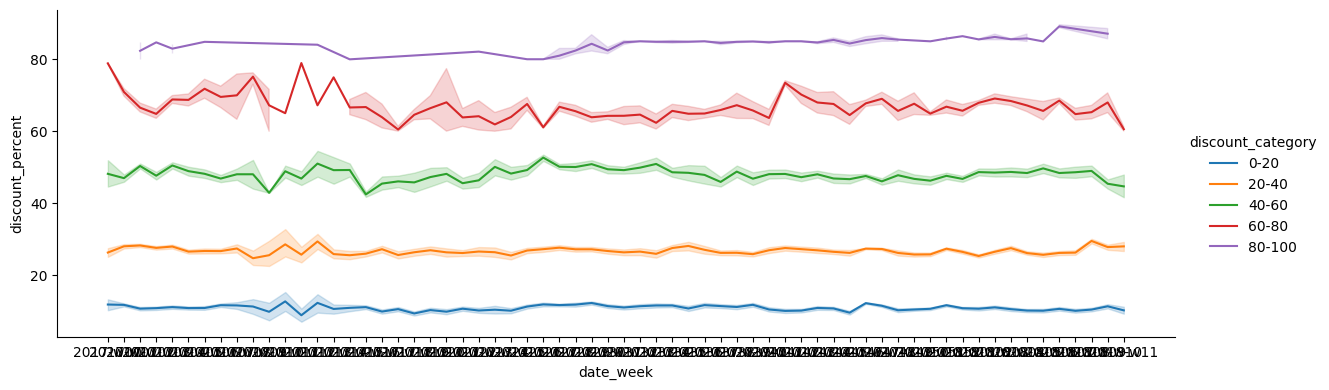

In [ ]:
# discount_percent distribution in each discount category throught time
sns.relplot(kind='line', data=orderlines_discount_qu, x='date_week', y='discount_percent', hue='discount_category', height=4, aspect=3)

### REVENUE by DISCOUNT CATEGORY

Text(22.569444444444443, 0.5, 'Discount category')

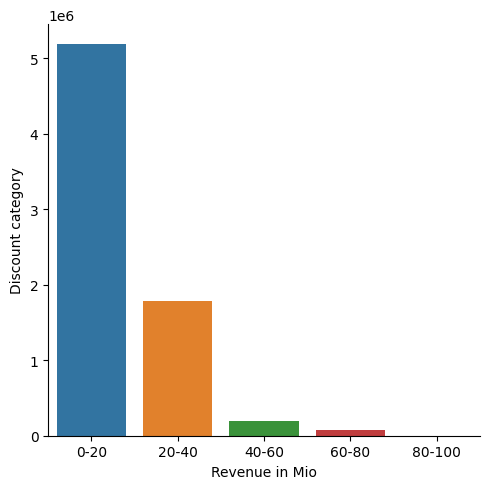

In [ ]:
# TOTAL REVENUE vs discount_category
df1 = orderlines_discount_qu.groupby(by='discount_category')['unit_sum'].sum().sort_values().reset_index()


df1.plot.bar(figsize=(6,4))

sns.catplot(kind='bar', data=df1, y='unit_sum', x='discount_category')
plt.xlabel('Revenue in Mio')
plt.ylabel('Discount category')


Text(5.069444444444445, 0.5, 'Average revenue')

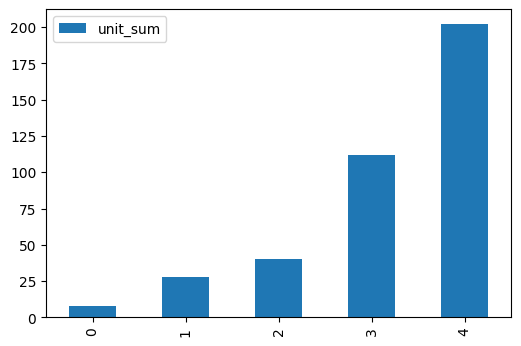

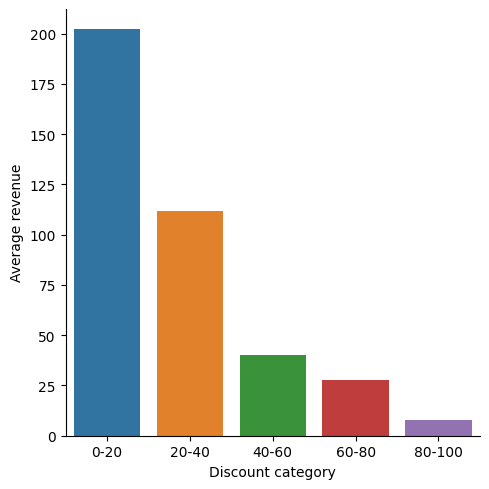

In [ ]:
# AVERAGE REVENUE per orderline vs discount_category
df1 = orderlines_discount_qu.groupby(by='discount_category')['unit_sum'].mean().sort_values().reset_index()

sns.catplot(kind='bar', data=df1, y='unit_sum', x='discount_category')
plt.xlabel('Discount category')
plt.ylabel('Average revenue')


In [ ]:
# grouping by days and discount_category
ol_disc_cat_days = orderlines_discount_qu.groupby(
    [orderlines_discount_qu['date_day'],
     orderlines_discount_qu.discount_category,
     # orderlines_discount_qu.price_category
     ]
    ).agg(
        {'discount_percent': 'mean', 'unit_sum': 'sum', 'product_quantity': 'sum'}
          ).reset_index()

ol_disc_cat_weeks = orderlines_discount_qu.groupby(
    [orderlines_discount_qu['date_week'],
     orderlines_discount_qu.discount_category,
     # orderlines_discount_qu.price_category
     ]
    ).agg(
        {'discount_percent': 'mean', 'unit_sum': 'sum', 'product_quantity': 'sum'}
          ).reset_index()


# grouping by days and discount_category
ol_disc_cat_weeks_avg_revenue = orderlines_discount_qu.groupby(
    [orderlines_discount_qu['date_week'],
     orderlines_discount_qu.discount_category,
     # orderlines_discount_qu.price_category
     ]
    ).agg(
        {'discount_percent': 'mean', 'unit_sum': 'mean', 'product_quantity': 'sum'}
          ).reset_index()



Text(46.235787877888555, 0.5, 'Revenue')

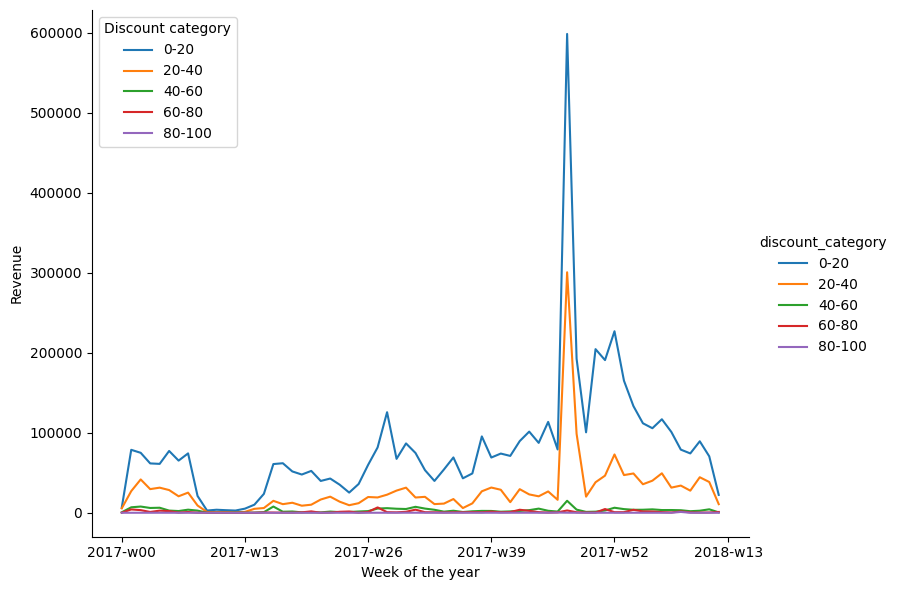

In [ ]:
sns.relplot(data=ol_disc_cat_weeks, x='date_week', y='unit_sum', kind='line', hue='discount_category', height=6, aspect=1.3)
import matplotlib.pyplot as plt
plt.legend(loc='upper left', title='Discount category')
plt.xticks(['2017-w00', '2017-w13', '2017-w26', '2017-w39', '2017-w52', '2018-w13'])
# plt.yticks([200000, 400000, 600000]);
plt.xlabel('Week of the year')
plt.ylabel('Revenue')

# or to plot it on the separate subplots:
## sns.relplot(data=ol_disc_cat_weeks, x='date_week', y='unit_sum', row='discount_category', hue='discount_category', kind='line', height=3, aspect=3)

Text(41.56678413857233, 0.5, 'Average revenue per orderline')

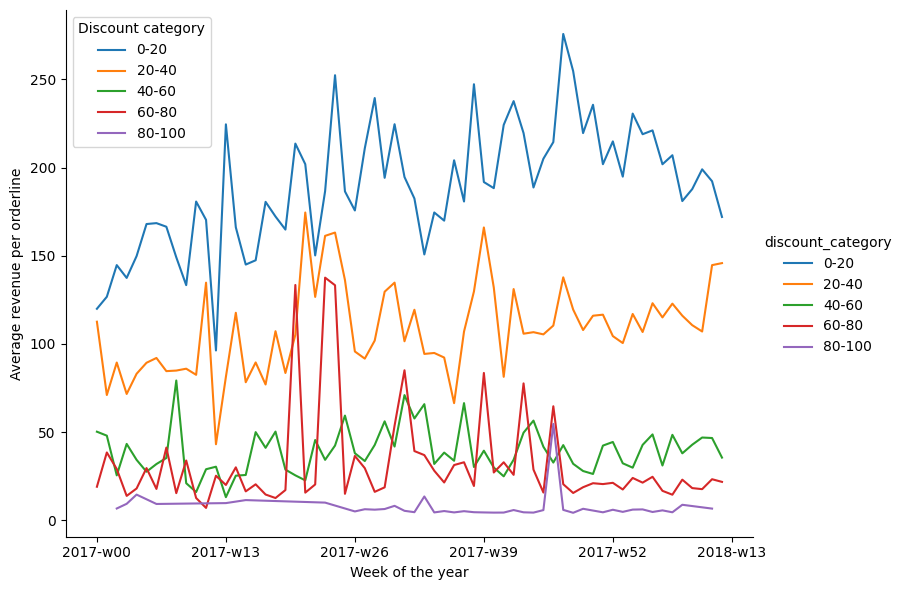

In [ ]:
sns.relplot(data=ol_disc_cat_weeks_avg_revenue, x='date_week', y='unit_sum', kind='line', hue='discount_category', height=6, aspect=1.3)
import matplotlib.pyplot as plt
plt.legend(loc='upper left', title='Discount category')
plt.xticks(['2017-w00', '2017-w13', '2017-w26', '2017-w39', '2017-w52', '2018-w13'])
# plt.yticks([200000, 400000, 600000]);
plt.xlabel('Week of the year')
plt.ylabel('Average revenue per orderline')

# or to plot it on the separate subplots:
## sns.relplot(data=ol_disc_cat_weeks, x='date_week', y='unit_sum', row='discount_category', hue='discount_category', kind='line', height=3, aspect=3)

Text(41.56678413857233, 0.5, 'Average revenue per orderline')

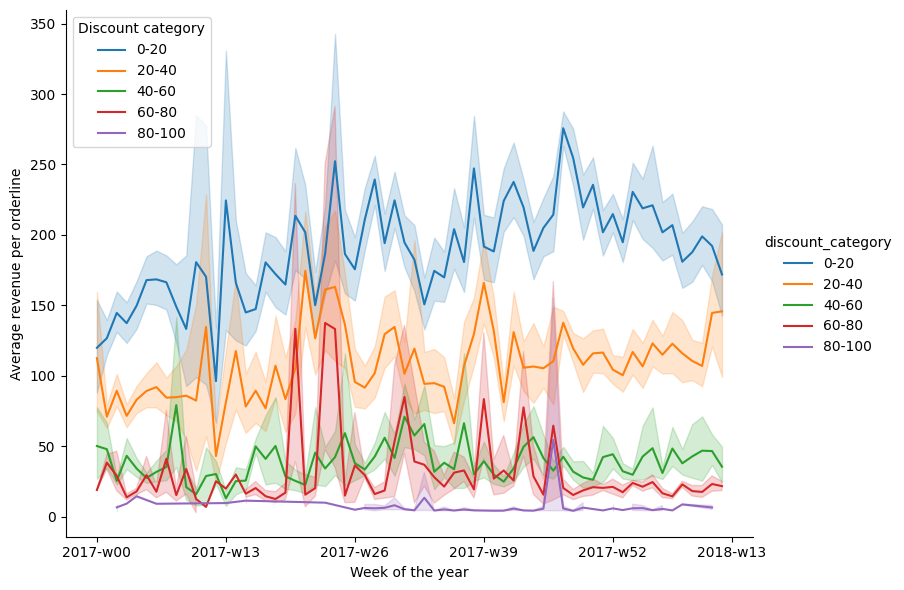

In [ ]:
sns.relplot(data=orderlines_discount_qu, x='date_week', y='unit_sum', kind='line', hue='discount_category', height=6, aspect=1.3)
import matplotlib.pyplot as plt
plt.legend(loc='upper left', title='Discount category')
plt.xticks(['2017-w00', '2017-w13', '2017-w26', '2017-w39', '2017-w52', '2018-w13'])
# plt.yticks([200000, 400000, 600000]);
plt.xlabel('Week of the year')
plt.ylabel('Average revenue per orderline')

# or to plot it on the separate subplots:
## sns.relplot(data=ol_disc_cat_weeks, x='date_week', y='unit_sum', row='discount_category', hue='discount_category', kind='line', height=3, aspect=3)

In [ ]:
ol_disc_cat_weeks.date_week

0      2017-w00
1      2017-w00
2      2017-w00
3      2017-w00
4      2017-w00
5      2017-w01
6      2017-w01
7      2017-w01
8      2017-w01
9      2017-w01
         ...   
310    2018-w10
311    2018-w10
312    2018-w10
313    2018-w10
314    2018-w10
315    2018-w11
316    2018-w11
317    2018-w11
318    2018-w11
319    2018-w11
Name: date_week, Length: 320, dtype: object

Text(0.5, 29.00000000000003, 'Week of the year')

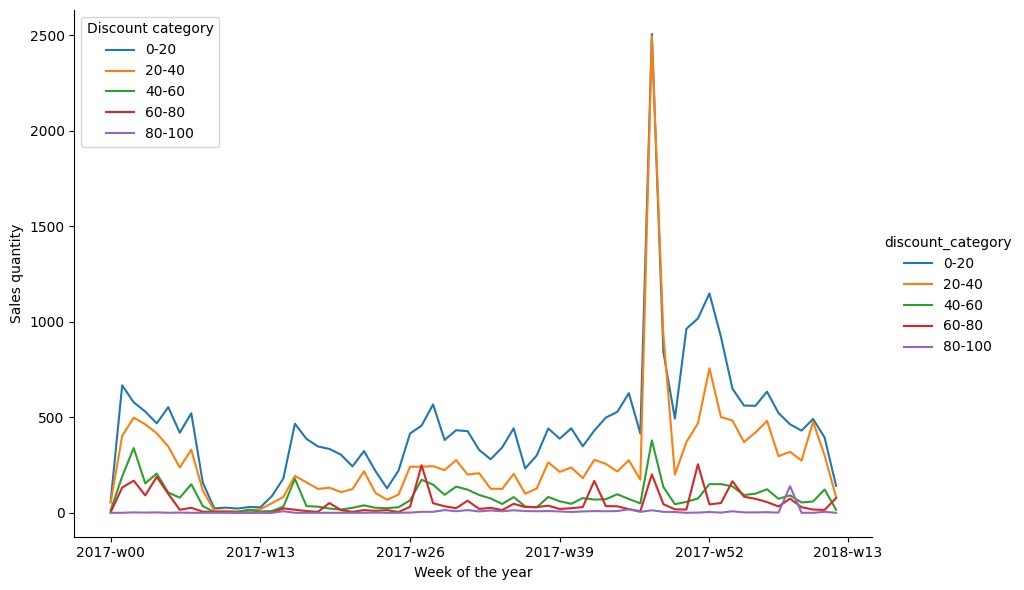

In [ ]:
sns.relplot(data=ol_disc_cat_weeks, x='date_week', y='product_quantity', kind='line', hue='discount_category', height=6, aspect=1.5)
plt.ylabel('Sales quantity')
plt.legend(loc='upper left', title='Discount category')
plt.xticks(['2017-w00', '2017-w13', '2017-w26', '2017-w39', '2017-w52', '2018-w13'])
plt.xlabel('Week of the year')

Text(0.5, 29.00000000000003, 'Week of the year')

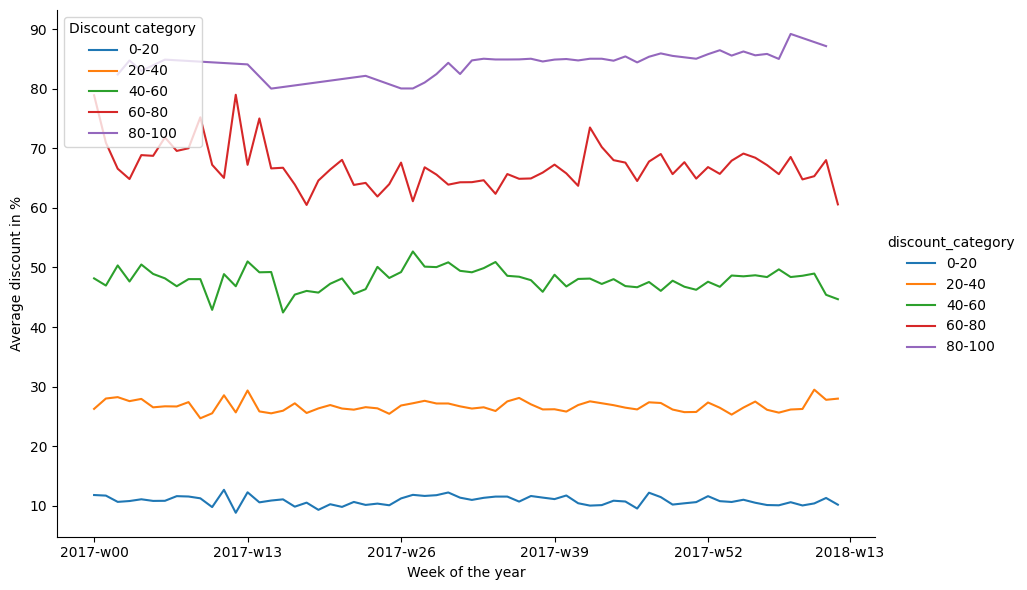

In [ ]:
sns.relplot(data=ol_disc_cat_weeks, x='date_week', y='discount_percent', kind='line', hue='discount_category', height=6, aspect=1.5)
plt.ylabel('Average discount in %')
plt.legend(loc='upper left', title='Discount category')
plt.xticks(['2017-w00', '2017-w13', '2017-w26', '2017-w39', '2017-w52', '2018-w13'])
plt.xlabel('Week of the year')

### APPLE vs non-APPLE products

In [ ]:
ol_disc_apple_weeks = orderlines_discount_qu.loc[
    orderlines_discount_qu['long'] == 'Apple'
    ].groupby(
    [orderlines_discount_qu['date_week'],
     orderlines_discount_qu.discount_category,
     ]
    ).agg(
        {'discount_percent': 'mean', 'unit_sum': 'mean', 'product_quantity': 'sum'}
          ).reset_index()

ol_disc_non_apple_weeks = orderlines_discount_qu.loc[
    (orderlines_discount_qu['long'] != 'Apple')
    ].groupby(
    [orderlines_discount_qu['date_week'],
     orderlines_discount_qu.discount_category,
     ]
    ).agg(
        {'discount_percent': 'mean', 'unit_sum': 'mean', 'product_quantity': 'sum'}
          ).reset_index()



In [ ]:
# corellation between product brand and discount_category
# sns.catplot(data=orderlines_discount_qu, x='discount_percent', y='long', kind='box', height=20, aspect=2)

Text(35.534727752057606, 0.5, 'Average revenue per orderline')

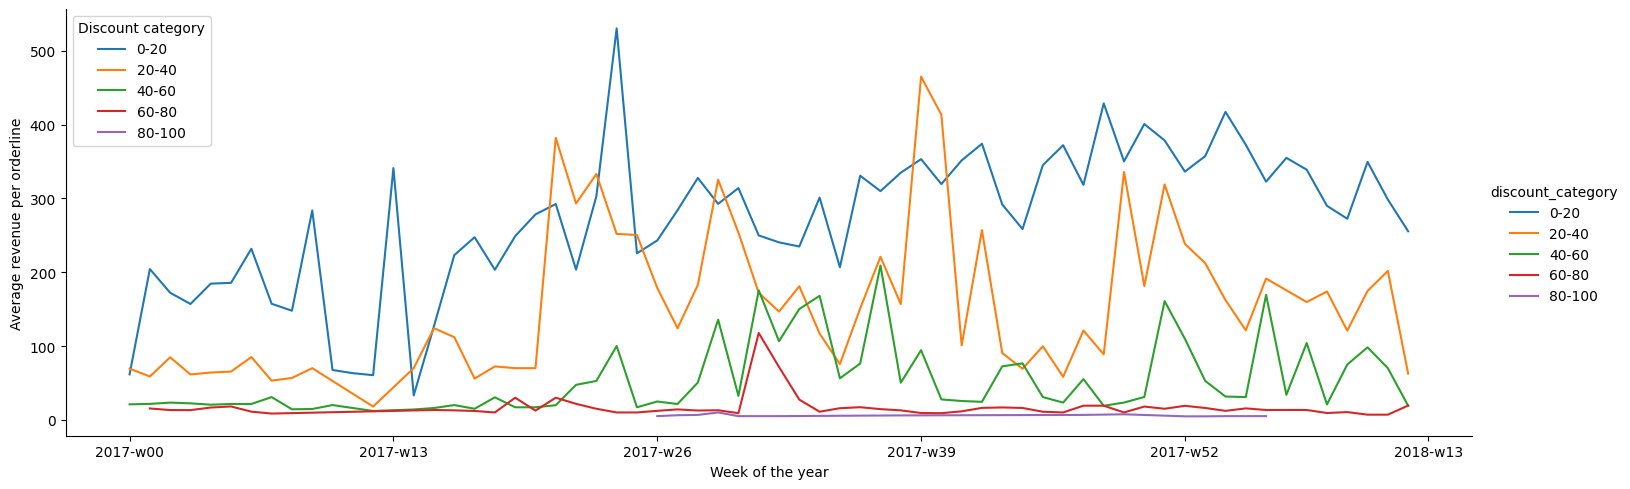

In [ ]:
# Apple products sales revenue
sns.relplot(data=ol_disc_apple_weeks, x='date_week', y='unit_sum', kind='line', hue='discount_category',  height=5, aspect=3)
plt.legend(loc='upper left', title='Discount category')
plt.xticks(['2017-w00', '2017-w13', '2017-w26', '2017-w39', '2017-w52', '2018-w13'])
plt.xlabel('Week of the year')
plt.ylabel('Average revenue per orderline')

Text(34.44560646004801, 0.5, 'Average revenue per orderline')

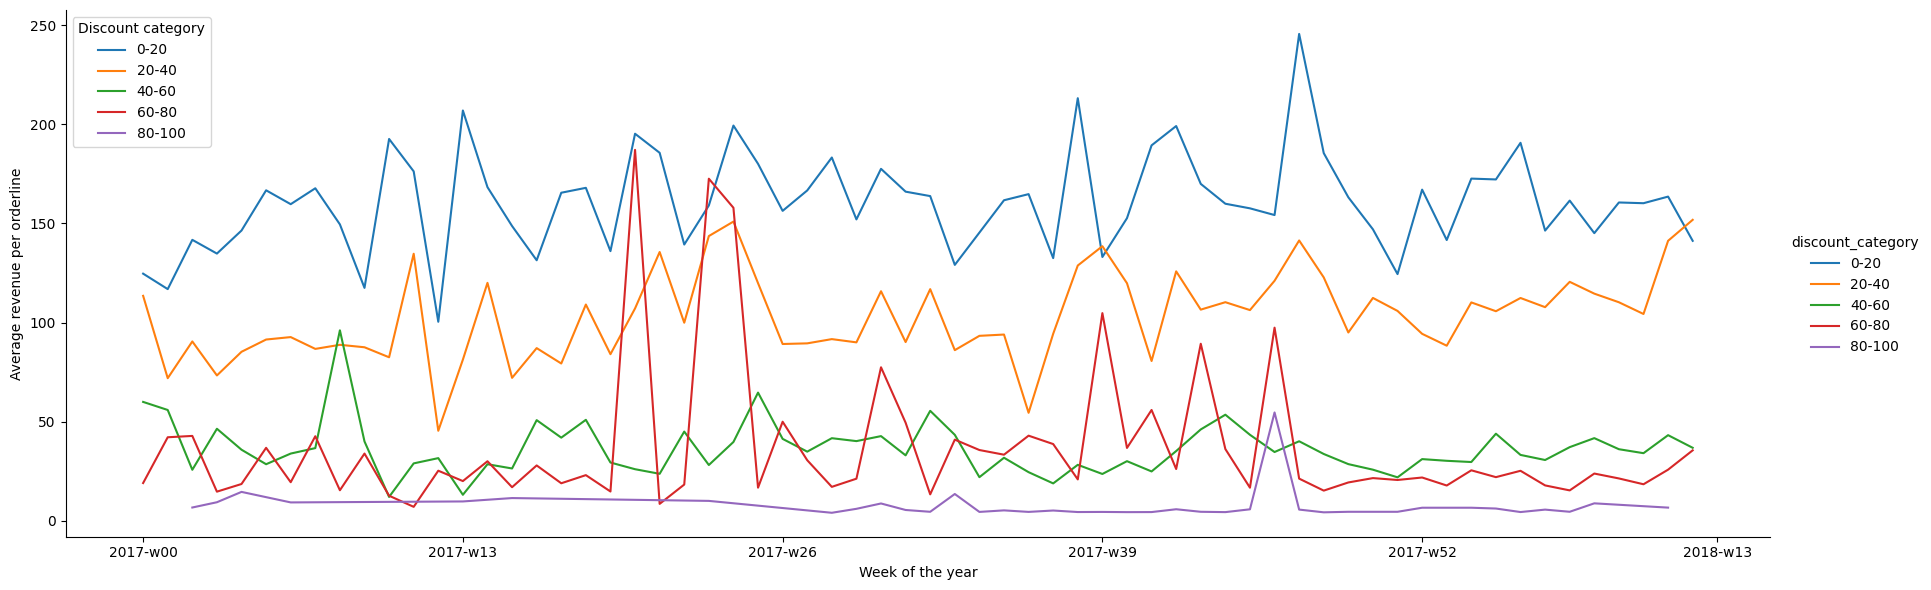

In [ ]:
# non Apple sales revenue
sns.relplot(data=ol_disc_non_apple_weeks, x='date_week', y='unit_sum', kind='line', hue='discount_category', height=6, aspect=3)
plt.legend(loc='upper left', title='Discount category')
plt.xticks(['2017-w00', '2017-w13', '2017-w26', '2017-w39', '2017-w52', '2018-w13'])
plt.xlabel('Week of the year')
plt.ylabel('Average revenue per orderline')

In [ ]:
# what products were sold during the peak in July 2017
orderlines_discount_qu.loc[
    (orderlines_discount_qu['long'] == 'Apple') &
    (orderlines_discount_qu['discount_category'].isin(['40-60', '60-80'])) &
    (orderlines_discount_qu['date'].between('2017-07-01', '2017-08-01'))
    ]['name'].value_counts()

Apple Lightning Cable Connector to USB 1m White (OEM)                     57
EarPods Apple Headphones with Remote and Mic (OEM)                        40
OEM 5W USB Power Adapter iPhone iPod and compatible Apple iPod             9
Like new - Apple AirPort Express Base Station                              6
Open - Apple Thunderbolt Adapter 3 / USB-C Thunderbolt 2 White             2
Like new - Apple Thunderbolt Cable 2m White                                2
Like new - Apple Case iPhone 6 Plus / 6s Plus Silicone Case White          1
Like new - Apple Lightning to USB Cable 2m-C                               1
Like new - Apple iPhone 6 16GB Silver                                      1
Like New - iPhone 5s 16GB Space Gray                                       1
Like new - Apple Watch 38mm Case Blue aluminum sports strap                1
Like new - Apple Watch 42mm steel case and strap Milanese Loop Silver      1
Like new - Apple Watch 42mm stainless steel case and strap Black sport     1

In [ ]:
ol_disc_apple_weeks['unit_sum'].sum()

2328174.49

In [ ]:
ol_disc_non_apple_weeks['unit_sum'].sum()

4913948.93

In [ ]:
orderlines_discount_qu['unit_sum'].sum()

7483721.459999999

### Refurbished vs new

#### Total revenue

In [ ]:
ol_disc_old_weeks = orderlines_discount_qu.loc[
    orderlines_discount_qu['refurbished'] == 'yes'
    ].groupby(
    [orderlines_discount_qu['date_week'],
     orderlines_discount_qu.discount_category,
     # orderlines_discount_qu.price_category
     ]
    ).agg(
        {'discount_percent': 'mean', 'unit_sum': 'sum', 'product_quantity': 'sum'}
          ).reset_index()

ol_disc_new_weeks = orderlines_discount_qu.loc[
    ~(orderlines_discount_qu['long'] == 'yes')
    ].groupby(
    [orderlines_discount_qu['date_week'],
     orderlines_discount_qu.discount_category,
     # orderlines_discount_qu.price_category
     ]
    ).agg(
        {'discount_percent': 'mean', 'unit_sum': 'sum', 'product_quantity': 'sum'}
          ).reset_index()


Text(35.794429762517126, 0.5, 'Revenue')

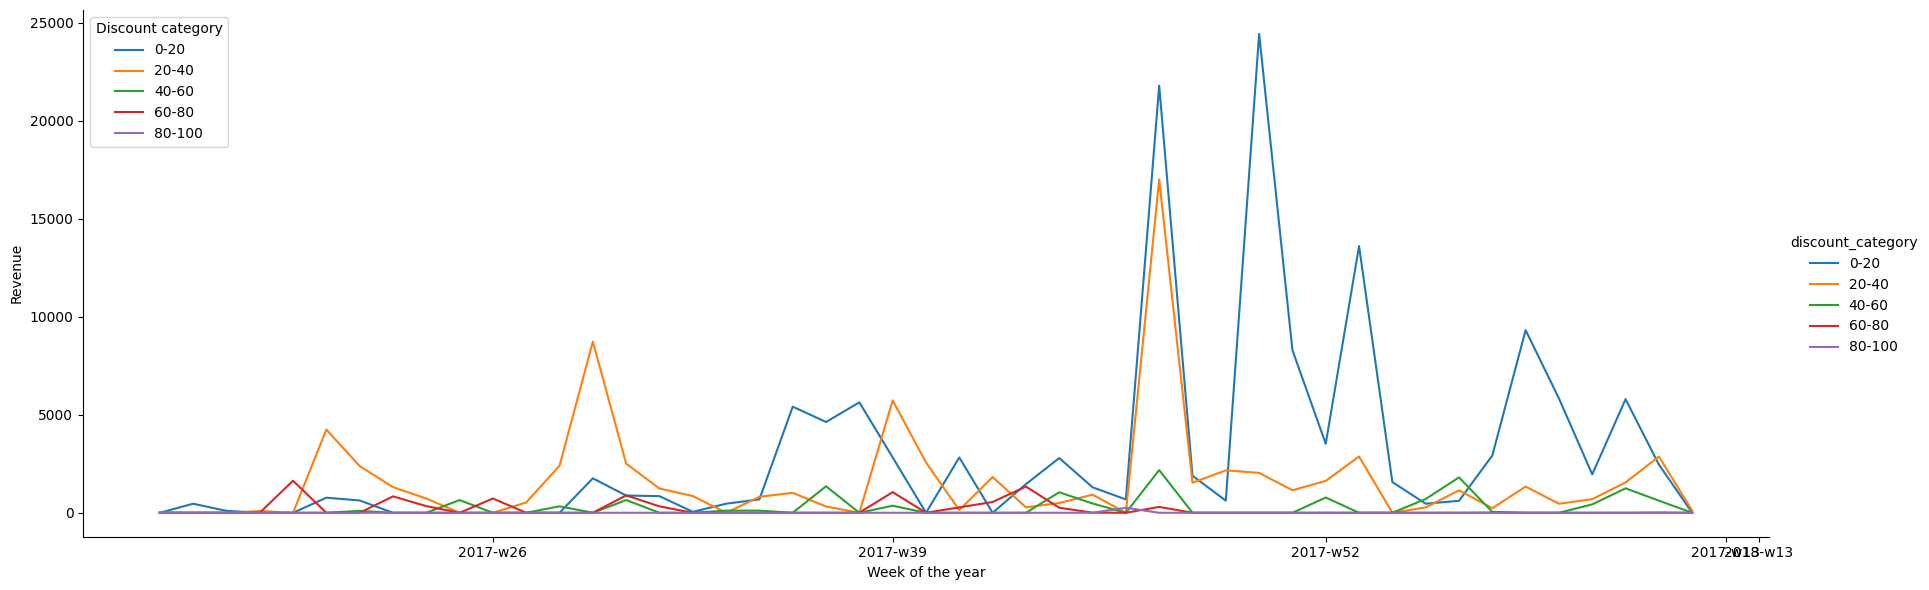

In [ ]:
sns.relplot(data=ol_disc_old_weeks, x='date_week', y='unit_sum', kind='line', hue='discount_category', height=6, aspect=3)
plt.legend(loc='upper left', title='Discount category')
plt.xticks(['2017-w13', '2017-w26', '2017-w39', '2017-w52', '2018-w13'])
plt.xlabel('Week of the year')
plt.ylabel('Revenue')

Text(36.46884141375169, 0.5, 'Revenue')

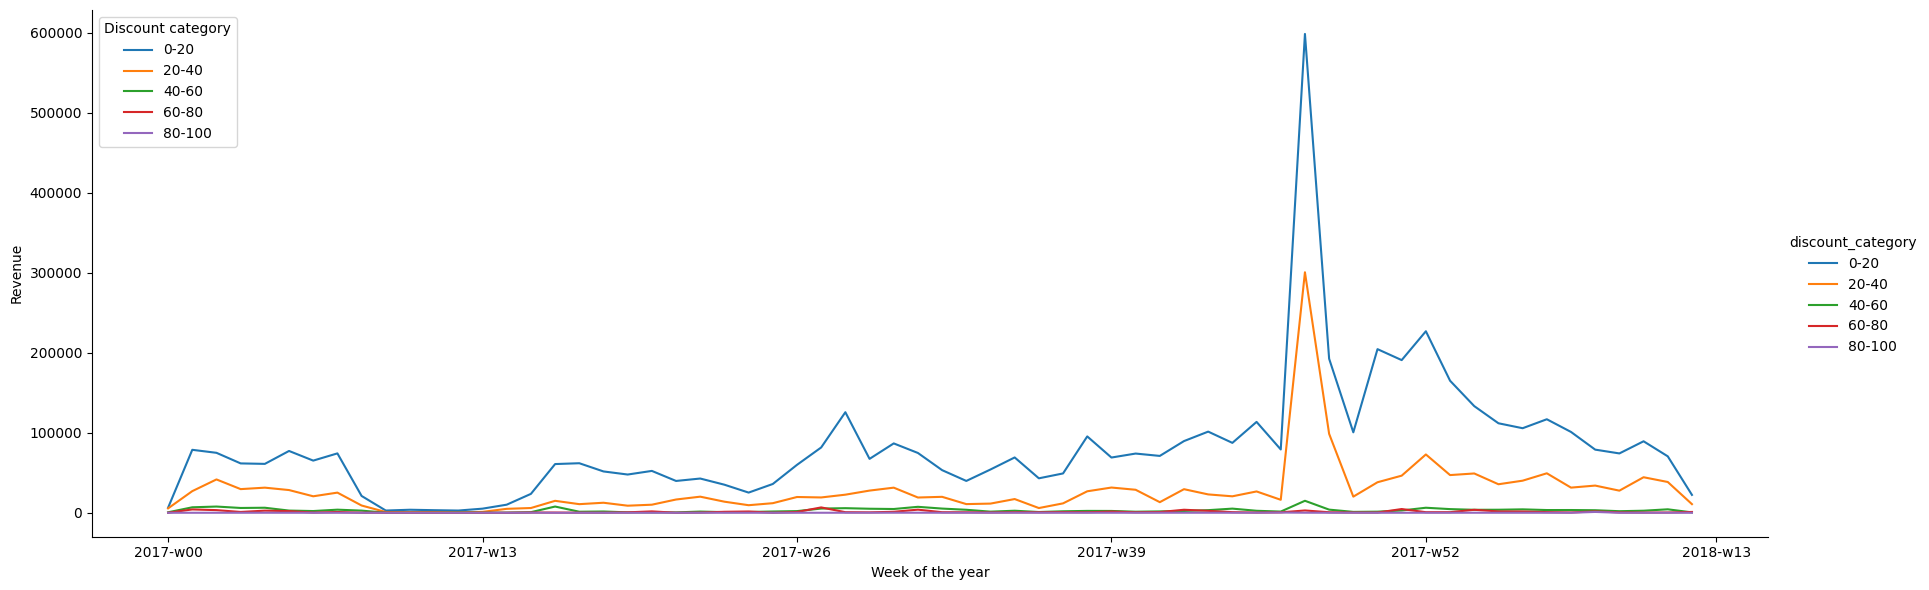

In [ ]:
sns.relplot(data=ol_disc_new_weeks, x='date_week', y='unit_sum', kind='line', hue='discount_category', height=6, aspect=3)
plt.legend(loc='upper left', title='Discount category')
plt.xticks(['2017-w00', '2017-w13', '2017-w26', '2017-w39', '2017-w52', '2018-w13'])
plt.xlabel('Week of the year')
plt.ylabel('Revenue')

#### Average revenue per orderline

In [ ]:
ol_disc_old_weeks_avg = orderlines_discount_qu.loc[
    orderlines_discount_qu['refurbished'] == 'yes'
    ].groupby(
    [orderlines_discount_qu['date_week'],
     orderlines_discount_qu.discount_category,
     # orderlines_discount_qu.price_category
     ]
    ).agg(
        {'discount_percent': 'mean', 'unit_sum': 'mean', 'product_quantity': 'sum'}
          ).reset_index()

ol_disc_new_weeks_avg = orderlines_discount_qu.loc[
    ~(orderlines_discount_qu['long'] == 'yes')
    ].groupby(
    [orderlines_discount_qu['date_week'],
     orderlines_discount_qu.discount_category,
     # orderlines_discount_qu.price_category
     ]
    ).agg(
        {'discount_percent': 'mean', 'unit_sum': 'mean', 'product_quantity': 'sum'}
          ).reset_index()


Text(35.120018111282576, 0.5, 'Average revenue per orderline')

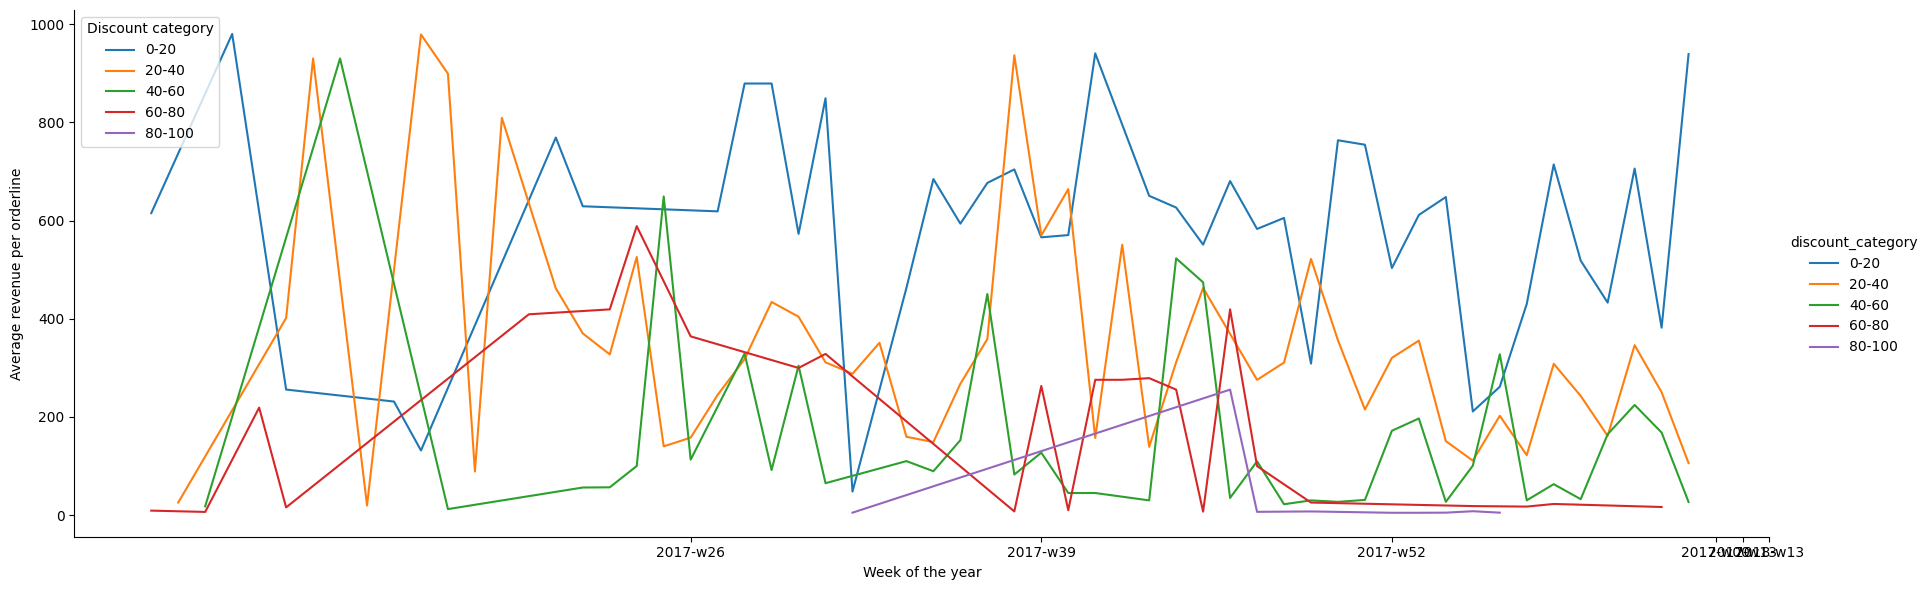

In [ ]:
sns.relplot(data=ol_disc_old_weeks_avg, x='date_week', y='unit_sum', kind='line', hue='discount_category', height=6, aspect=3)
plt.legend(loc='upper left', title='Discount category')
plt.xticks(['2017-w00', '2017-w13', '2017-w26', '2017-w39', '2017-w52', '2018-w13'])
plt.xlabel('Week of the year')
plt.ylabel('Average revenue per orderline')

Text(34.44560646004801, 0.5, 'Average revenue per orderline')

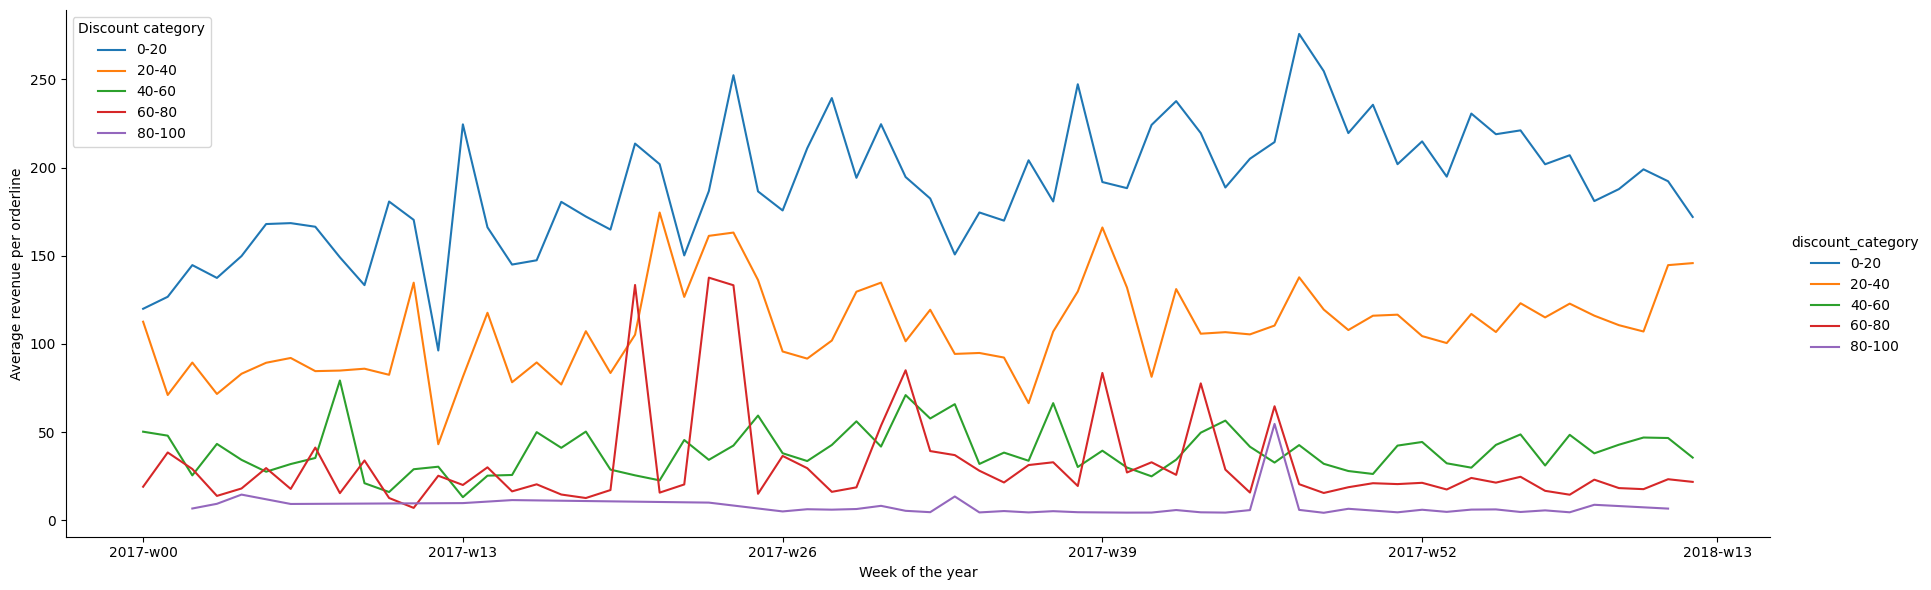

In [ ]:
sns.relplot(data=ol_disc_new_weeks_avg, x='date_week', y='unit_sum', kind='line', hue='discount_category', height=6, aspect=3)
plt.legend(loc='upper left', title='Discount category')
plt.xticks(['2017-w00', '2017-w13', '2017-w26', '2017-w39', '2017-w52', '2018-w13'])
plt.xlabel('Week of the year')
plt.ylabel('Average revenue per orderline')

### Defining product categories

#### Asim's method

HINT!!!! to further divide to product categories look at last digits of "type"

In [ ]:
pd.set_option("max_colwidth", 70)
orderlines_discount_qu['prod_cat'] = 'others'

orderlines_discount_qu.loc[orderlines_discount_qu["desc"].str.contains("keyboard", case=False), "prod_cat"] = "Keyboards&accessories"
orderlines_discount_qu.loc[orderlines_discount_qu["name"].str.contains("keyboard", case=False), "prod_cat"] = "Keyboards&accessories"
orderlines_discount_qu.loc[orderlines_discount_qu["name"].str.contains(r'(?=.*tablet)(?=.*graphic)', regex=True, case=False), "prod_cat"] = "Graphic tablet"
orderlines_discount_qu.loc[orderlines_discount_qu["desc"].str.contains(r'(?=.*tablet)(?=.*graphic)', regex=True, case=False), "prod_cat"] = "Graphic tablet"
orderlines_discount_qu.loc[orderlines_discount_qu["name"].str.contains("iPhone",case=False) & (orderlines_discount_qu["name"].str.contains("GB",case=False)), "prod_cat"] = "Iphone"
orderlines_discount_qu.loc[orderlines_discount_qu["desc"].str.contains("iPhone",case=False) & (orderlines_discount_qu["desc"].str.contains("GB",case=False)), "prod_cat"] = "Iphone"
orderlines_discount_qu.loc[orderlines_discount_qu["name"].str.contains("iPad",case=False) & (orderlines_discount_qu["name"].str.contains("GB",case=False)), "prod_cat"] = "Ipad"
orderlines_discount_qu.loc[orderlines_discount_qu["desc"].str.contains("Headphone", case=False), "prod_cat"] = "Sound devices"
orderlines_discount_qu.loc[orderlines_discount_qu["name"].str.contains("Headphone", case=False), "prod_cat"] = "Sound devices"
orderlines_discount_qu.loc[orderlines_discount_qu["desc"].str.contains("speaker", case=False), "prod_cat"] = "Sound devices"
orderlines_discount_qu.loc[orderlines_discount_qu["desc"].str.contains("earphones", case=False), "prod_cat"] = "Sound devices"
orderlines_discount_qu.loc[orderlines_discount_qu["desc"].str.contains("headset", case=False), "prod_cat"] = "Sound devices"
orderlines_discount_qu.loc[orderlines_discount_qu["name"].str.contains("dock",case=False), "prod_cat"] = "Docks,adaptors,chargers&cable"
orderlines_discount_qu.loc[orderlines_discount_qu["desc"].str.contains("dock",case=False), "prod_cat"] = "Docks,adaptors,chargers&cable"
orderlines_discount_qu.loc[orderlines_discount_qu["name"].str.contains("RAM", case=False), "prod_cat"] = "RAM"
orderlines_discount_qu.loc[orderlines_discount_qu["desc"].str.contains("RAM", case=False), "prod_cat"] = "RAM"
orderlines_discount_qu.loc[orderlines_discount_qu["desc"].str.contains("DDR3", case=False), "prod_cat"] = "RAM"
orderlines_discount_qu.loc[orderlines_discount_qu["name"].str.contains("cable",case=False), "prod_cat"] = "Docks,adaptors,chargers&cable"
orderlines_discount_qu.loc[orderlines_discount_qu["desc"].str.contains("cable",case=False), "prod_cat"] = "Docks,adaptors,chargers&cable"
orderlines_discount_qu.loc[orderlines_discount_qu["name"].str.contains("adaptor",case=False), "prod_cat"] = "Docks,adaptors,chargers&cable"
orderlines_discount_qu.loc[orderlines_discount_qu["desc"].str.contains("adaptor",case=False), "prod_cat"] = "Docks,adaptors,chargers&cable"
orderlines_discount_qu.loc[orderlines_discount_qu["desc"].str.contains("charger",case=False), "prod_cat"] = "Docks,adaptors,chargers&cable"
orderlines_discount_qu.loc[orderlines_discount_qu["desc"].str.contains("battery", case=False), "prod_cat"] = "Battery&accessories"
orderlines_discount_qu.loc[orderlines_discount_qu["name"].str.contains("battery", case=False), "prod_cat"] = "Battery&accessories"
orderlines_discount_qu.loc[orderlines_discount_qu["desc"].str.contains("mouse",case=False), "prod_cat"] = "Stylus&Mouse"
orderlines_discount_qu.loc[orderlines_discount_qu["name"].str.contains("mouse",case=False), "prod_cat"] = "Stylus&Mouse"
orderlines_discount_qu.loc[orderlines_discount_qu["desc"].str.contains("pencil",case=False), "prod_cat"] = "Stylus&Mouse"
orderlines_discount_qu.loc[orderlines_discount_qu["desc"].str.contains("Stylus", case=False) & (orderlines_discount_qu.prod_cat != 'Graphic tablet'), "prod_cat"] = "Stylus&Mouse"
orderlines_discount_qu.loc[orderlines_discount_qu["name"].str.contains("Stylus", case=False) & (orderlines_discount_qu.prod_cat != 'Graphic tablet'), "prod_cat"] = "Stylus&Mouse"
orderlines_discount_qu.loc[orderlines_discount_qu["type"] == ("11865403"), "prod_cat"] = "Protective_cover"
orderlines_discount_qu.loc[orderlines_discount_qu["type"] == ("12175397"), "prod_cat"] = "RAM"
orderlines_discount_qu.loc[orderlines_discount_qu["type"] == ("11935397"), "prod_cat"] = "External_storage"
orderlines_discount_qu.loc[orderlines_discount_qu["type"] == ("42945397"), "prod_cat"] = "External_storage"
orderlines_discount_qu.loc[orderlines_discount_qu["type"] == ("57445397"), "prod_cat"] = "External_storage"
orderlines_discount_qu.loc[orderlines_discount_qu["type"] == ("11905404"), "prod_cat"] = "Fitness&hobbies"
orderlines_discount_qu.loc[orderlines_discount_qu["type"] == ("12635403"), "prod_cat"] = "Cases and protections"
orderlines_discount_qu.loc[orderlines_discount_qu["type"] == ("13835403"), "prod_cat"] = "Cases and protections"
orderlines_discount_qu.loc[orderlines_discount_qu["type"] == ("11821715"), "prod_cat"] = "Ipod"
orderlines_discount_qu.loc[orderlines_discount_qu["type"] == ("12655397"), "prod_cat"] = "External_storage"
orderlines_discount_qu.loc[orderlines_discount_qu["name"].str.contains("Case", case=False), "prod_cat"] = "Cases and protections"
orderlines_discount_qu.loc[orderlines_discount_qu["name"].str.contains("datatraveler", case=False), "prod_cat"] = "External_storage"
orderlines_discount_qu.loc[orderlines_discount_qu["desc"].str.contains("tempered glass", case=False), "prod_cat"] = "Cases and protections"
orderlines_discount_qu.loc[orderlines_discount_qu["name"].str.contains("applecare", case=False), "prod_cat"] = "Warranty"
orderlines_discount_qu.loc[orderlines_discount_qu["type"] == ("1296"), "prod_cat"] = "Monitor"
orderlines_discount_qu.loc[orderlines_discount_qu["type"] == ("9094"), "prod_cat"] = "Camera"
orderlines_discount_qu.loc[orderlines_discount_qu["name"].str.contains(r'(?=.*Apple)(?=.*Mac)(?=.*GB)', regex=True, case=False), "prod_cat"] = "Apple_desktop&laptop"






In [ ]:
# code block only for control
orderlines_discount_qu.loc[orderlines_discount_qu['type'].isin(['9094'])][["name", "desc", "long", "type", "prod_cat"]]#.sample(20)
orderlines_discount_qu.loc[orderlines_discount_qu["name"].str.contains(r'(?=.*Apple)(?=.*Mac)(?=.*GB)', regex=True, case=False)][["name", "desc", "long", "type", "prod_cat"]].sample(10)
orderlines_discount_qu.loc[orderlines_discount_qu["desc"].str.contains("network camera", case=False)][["name", "desc", "long", "type", "prod_cat"]]#.sample(15)
orderlines_discount_qu.loc[orderlines_discount_qu["long"] == 'Western Digital'][["name", "desc", "long", "type", "prod_cat"]].sample(10)
# checking non-assigned products
orderlines_discount_qu.loc[orderlines_discount_qu["prod_cat"] == 'others'][["name", "desc", "long", "type", "prod_cat"]].sample(20)

,name,desc,long,type,prod_cat
437,D-Link DCS-932L Wireless IP Camera Cloud,Wireless network camera day and night home with my DLink.,D-Link,9094,others
796,D-Link DCS-932L Wireless IP Camera Cloud,Wireless network camera day and night home with my DLink.,D-Link,9094,others
2507,D-Link DCS 180 camera HD 960L Wi-Fi ac includes 16GB microsd,HD camera with panoramic 180 degree view angle anti-distortion tec...,D-Link,9094,RAM
2683,D-Link DCS-932L Wireless IP Camera Cloud,Wireless network camera day and night home with my DLink.,D-Link,9094,others
2710,D-Link DCS-932L Wireless IP Camera Cloud,Wireless network camera day and night home with my DLink.,D-Link,9094,others
3429,D-Link DCS-932L Wireless IP Camera Cloud,Wireless network camera day and night home with my DLink.,D-Link,9094,others
5180,Welcome Netatmo facial recognition camera,intelligent security camera with night vision and facial recogniti...,Netatmo,9094,others
6124,Welcome Netatmo facial recognition camera,intelligent security camera with night vision and facial recogniti...,Netatmo,9094,others
6408,D-Link DCS-932L Wireless IP Camera Cloud,Wireless network camera day and night home with my DLink.,D-Link,9094,others
6796,D-Link DCS 180 camera HD 960L Wi-Fi ac includes 16GB microsd,HD camera with panoramic 180 degree view angle anti-distortion tec...,D-Link,9094,RAM


In [ ]:
orderlines_discount_qu.prod_cat.value_counts(normalize=True)
orderlines_discount_qu.prod_cat.value_counts()

others                          0.22
Cases and protections           0.15
External_storage                0.13
Docks,adaptors,chargers&cable   0.08
RAM                             0.08
Fitness&hobbies                 0.06
Sound devices                   0.05
Battery&accessories             0.04
Iphone                          0.04
Monitor                         0.03
Warranty                        0.02
Graphic tablet                  0.02
Keyboards&accessories           0.02
Stylus&Mouse                    0.02
Ipad                            0.01
Apple_desktop&laptop            0.01
Protective_cover                0.00
Camera                          0.00
Ipod                            0.00
Name: prod_cat, dtype: float64

In [ ]:
orderlines_discount_qu.groupby(by='prod_cat')['unit_sum'].sum().sort_values(ascending=False)

prod_cat
Iphone                          1214233.35
External_storage                1145912.76
others                          1113213.77
RAM                              842872.75
Monitor                          601594.19
Cases and protections            442899.33
Ipad                             371294.00
Sound devices                    321546.65
Fitness&hobbies                  279629.24
Apple_desktop&laptop             241279.51
Docks,adaptors,chargers&cable    229263.23
Graphic tablet                   218964.09
Battery&accessories              160942.17
Warranty                          90539.31
Keyboards&accessories             85922.69
Stylus&Mouse                      80727.65
Camera                            22603.51
Ipod                              14681.09
Protective_cover                   5602.17
Name: unit_sum, dtype: float64

#### Plots for Revenue vs Product category

In [ ]:
ol_prod_cat_weeks = orderlines_discount_qu.groupby(
    [
     # orderlines_discount_qu['date_week'],
     orderlines_discount_qu.prod_cat,
     orderlines_discount_qu.discount_category
     ]
    ).agg(
        {'discount_percent': 'mean', 'unit_sum': 'sum', 'product_quantity': 'sum'}
          ).reset_index().sort_values('unit_sum')

ol_prod_cat_weeks_avg = orderlines_discount_qu.groupby(
    [
     # orderlines_discount_qu['date_week'],
     orderlines_discount_qu.prod_cat,
     orderlines_discount_qu.discount_category
     ]
    ).agg(
        {'discount_percent': 'mean', 'unit_sum': 'mean', 'product_quantity': 'sum'}
          ).reset_index().sort_values('unit_sum')


##### Total Revenue vs Product category

Text(9.444444444444452, 0.5, 'Revenue in Mio')

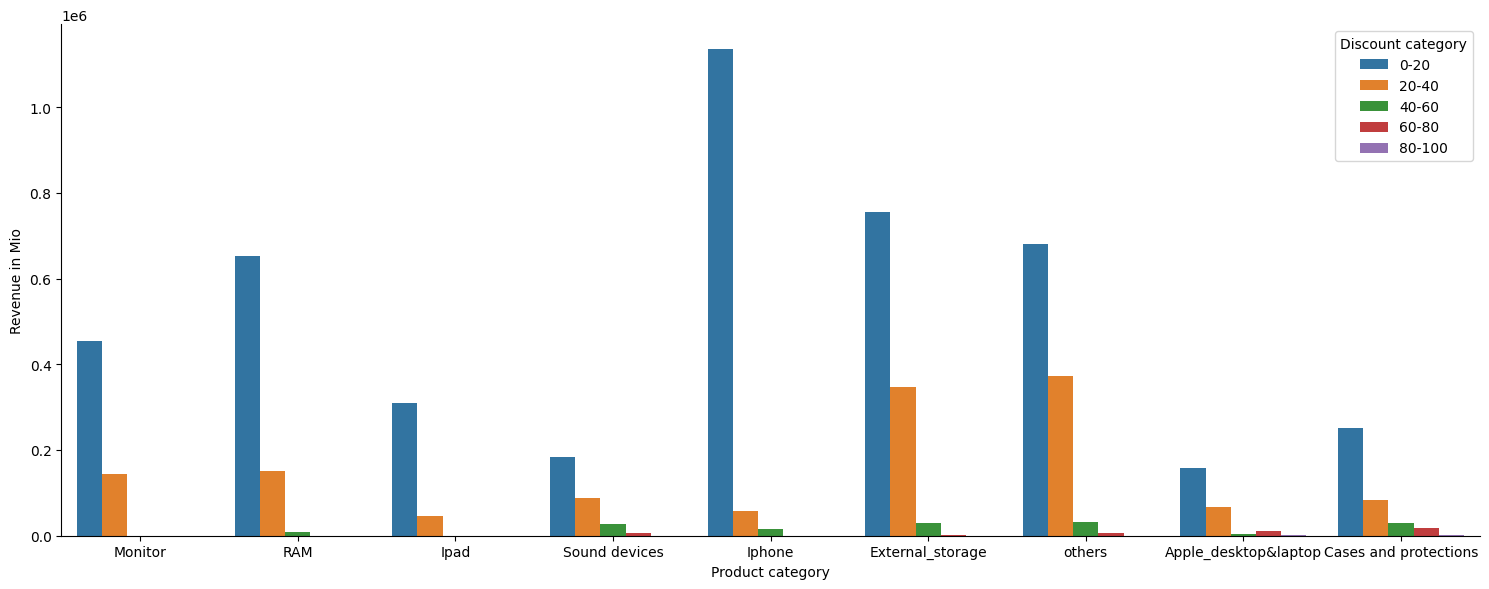

In [ ]:
sns.catplot(data=ol_prod_cat_weeks.loc[ol_prod_cat_weeks['prod_cat'].isin(['Cases and protections', 'External_storage', 'RAM', 'Docks,adaptors&cable', 'Apple_desktop&laptop', 'Sound devices', 'Iphone', 'Ipad', 'Monitor', 'others'])],
            y='unit_sum',
            x='prod_cat',
            hue='discount_category',
            kind='bar',
            height=6,
            aspect=2.5,
            legend=False)
plt.legend(loc='upper right', title='Discount category')
# plt.xticks(['2017-w13', '2017-w26', '2017-w39', '2017-w52', '2018-w13'])
# fig, axes = plt.subplots(4, 4)
plt.xlabel('Product category')
plt.ylabel('Revenue in Mio')

##### Average Revenue per orderline vs Product category

Text(5.069444444444452, 0.5, 'Revenue in Mio')

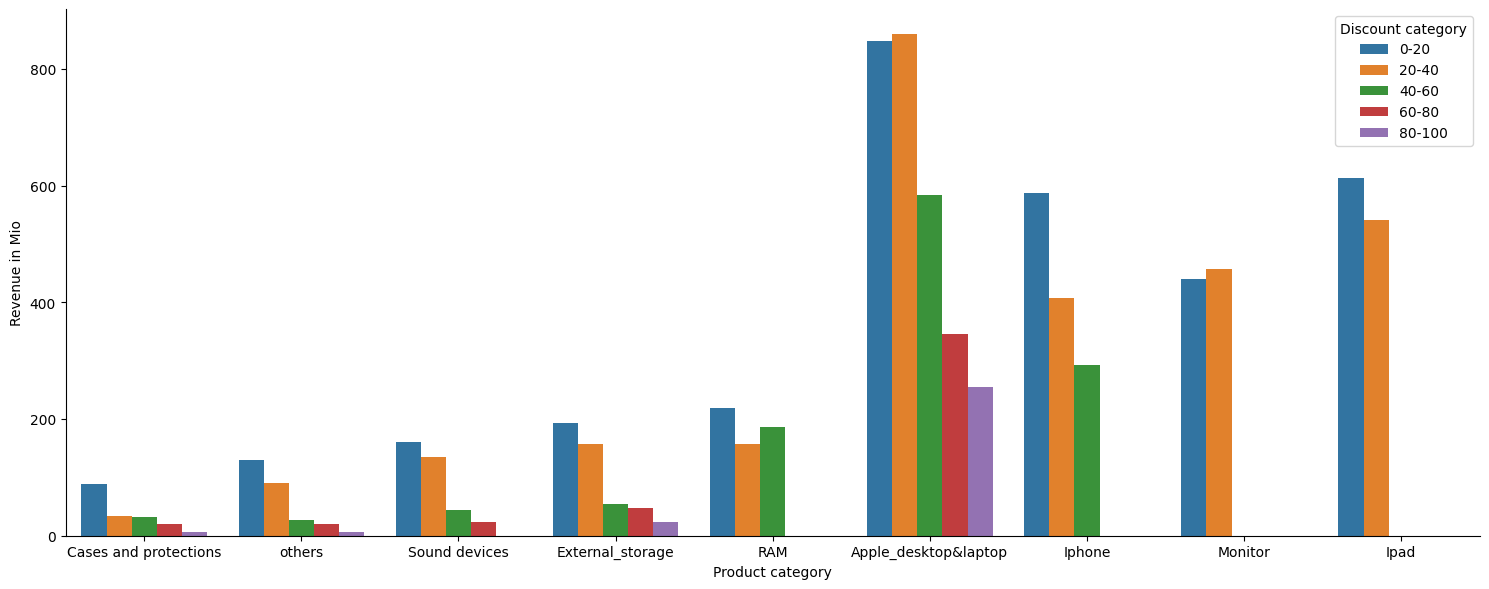

In [ ]:
sns.catplot(data=ol_prod_cat_weeks_avg.loc[ol_prod_cat_weeks_avg['prod_cat'].isin(['Cases and protections', 'External_storage', 'RAM', 'Docks,adaptors&cable', 'Apple_desktop&laptop', 'Sound devices', 'Iphone', 'Ipad', 'Monitor', 'others'])],
            y='unit_sum',
            x='prod_cat',
            hue='discount_category',
            kind='bar',
            height=6,
            aspect=2.5,
            legend=False)
plt.legend(loc='upper right', title='Discount category')
# plt.xticks(['2017-w13', '2017-w26', '2017-w39', '2017-w52', '2018-w13'])
# fig, axes = plt.subplots(4, 4)
plt.xlabel('Product category')
plt.ylabel('Average revenue per orderline')

## Work in progress

Text(34.44560646004801, 0.5, 'Average revenue per orderline')

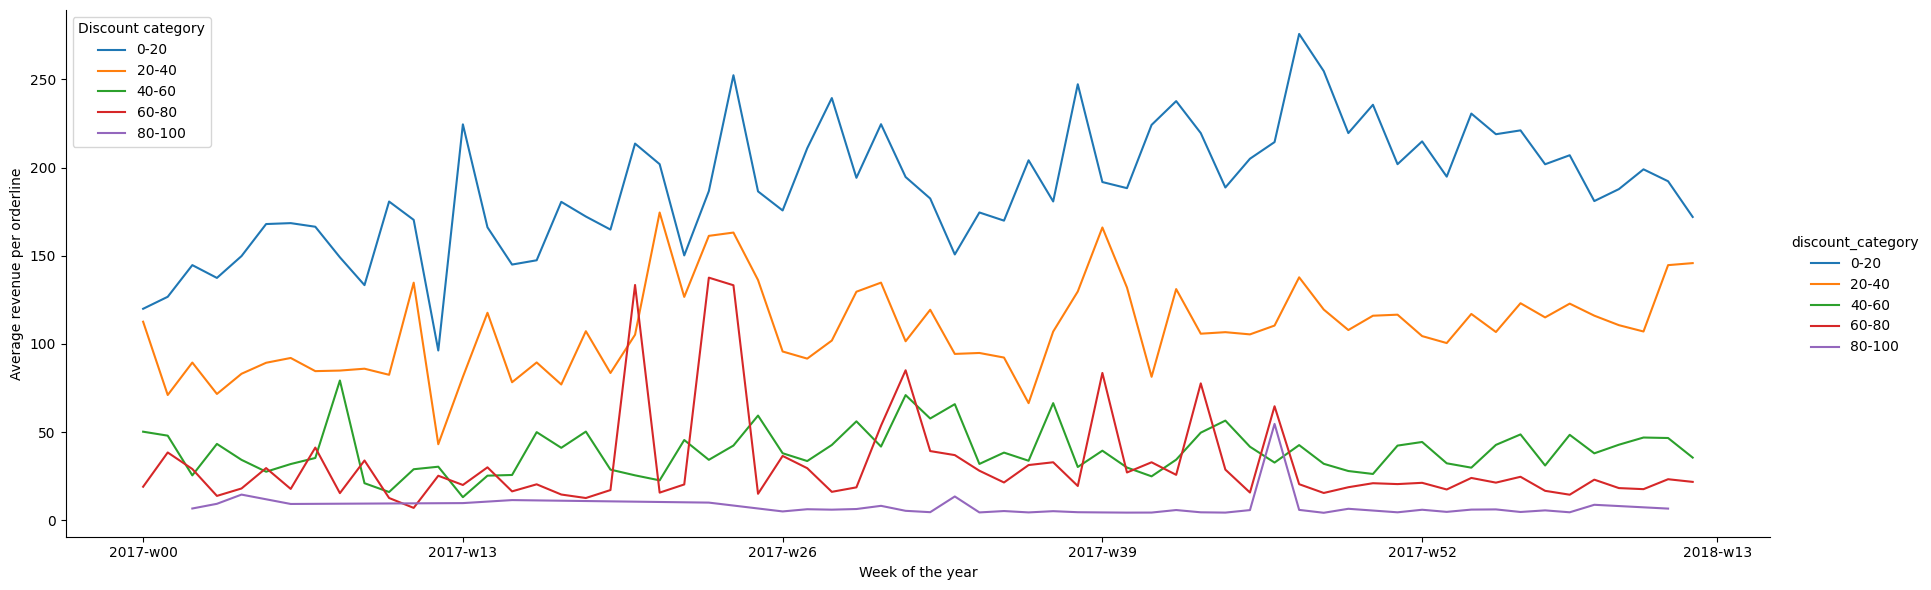

In [ ]:
# avg orderline revenue depending on discount category
ol_work = orderlines_discount_qu.groupby(
    [orderlines_discount_qu['date_week'],
     orderlines_discount_qu.discount_category,
     # orderlines_discount_qu.price_category
     ]
    ).agg(
        {'discount_percent': 'mean', 'unit_sum': 'mean', 'product_quantity': 'sum'}
          ).reset_index()
ol_work

sns.relplot(data=ol_work, x='date_week', y='unit_sum', kind='line', hue='discount_category', height=6, aspect=3)
plt.legend(loc='upper left', title='Discount category')
plt.xticks(['2017-w00', '2017-w13', '2017-w26', '2017-w39', '2017-w52', '2018-w13'])
plt.xlabel('Week of the year')
plt.ylabel('Average revenue per orderline')

In [ ]:
# Step 1: Define category mapping
category_mapping = {
    '11865403': 'Pro_cover  Apple',
    '12175397': 'other services and related acceories',
    '1298': 'Computers',
    '11935397': 'Computers',
    '11905404': 'Computers',
    '1282': 'Computers',
    '12635403': 'Pro_cover  Apple',
    '13835403': 'Pro_cover  Apple',
    '5,74E+15': 'iPhone',
    '1364': 'iPhone and phones related acceorries',
    '12585395': 'differents',
    '1296': 'Battery monitors and related comp. accessories',
    '1325': 'Battery monitors and related comp. accessories',
    '5384': 'iPhone and phones related acceorries',
    '1433': 'External storage',
    '12215397': 'Battery monitors and related comp. accessories',
    '5398': 'iPhone and phones related acceorries',
    '1,02E+12': 'Battery monitors and related comp. accessories',
    '1,44E+11': 'External storage',
    '57445397': 'iPhone and phones related acceorries',
    '1334': 'Battery monitors and related comp. accessories',
    '2158': 'iPhone and phones related acceorries',
    '2449': 'iPhone and phones related acceorries',
    '12655397': 'Battery monitors and related comp. accessories',
    '1229': 'iPhone and phones related acceorries',
    '12995397': 'External storage',
    '1515': 'Battery and related accessories',
    '13615399': 'differents',
    '13555403': 'iPhone and phones related acceorries',
    '1405': 'Battery monitors and related comp. accessories',
    '1230': 'iPhone and phones related acceorries',
    '118692158': 'others',
    '1216': 'iPhone and phones related acceorries',
    '24885185': 'iPhone and phones related acceorries',
    '24895185': 'iPhone and phones related acceorries'
}
# Step 2: Assign categories based on serial numbers
orderlines_discount_qu['prod_cat'] = orderlines_discount_qu['type'].map(category_mapping)
# Step 3: Assign 'Other' category to remaining values
remaining_serials = set(orderlines_discount_qu['type']) - set(category_mapping.keys())
orderlines_discount_qu.loc[orderlines_discount_qu['type'].isin(remaining_serials), 'prod_cat'] = 'Others'
# Step 4: Assign 'Other (Including all remaining categories and types)' to unmatched rows
orderlines_discount_qu['prod_cat'].fillna('Others', inplace=True)